# Factor-Based Investment Strategies: Evaluating Linear and Nonlinear Models for S&P 500 Prediction

## Introduction

This project investigates whether factor-based investment strategies can outperform a passive market benchmark when evaluated using a realistic, walk-forward framework. Specifically, we compare three approaches:

- **SPY (Benchmark)**: A passive buy-and-hold strategy representing market performance.
- **Linear Fama–French Five-Factor Model**: A theory-driven, interpretable regression model with time-varying factor loadings.
- **XGBoost Regression Model**: A nonlinear machine learning model designed to capture complex relationships between factors and returns.

While factor models are widely used in academic finance, their real-world performance depends on market regime, model assumptions, and evaluation methodology. This study evaluates whether increasing model complexity leads to improved risk-adjusted performance, rather than simply higher raw returns.

In this tutorial, we will walk through the entire process of data curation, exploratory data analysis, model building, and evaluation. We'll use Python libraries such as pandas, scikit-learn, and XGBoost to implement and compare these strategies.

In [1]:
import os
import re
import zipfile
from io import BytesIO, StringIO
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import yfinance as yf
from scipy.stats import pearsonr
from IPython.display import display

plt.style.use("seaborn-v0_8")

USE_CACHED_DATA = True
ALLOW_DOWNLOADS = not USE_CACHED_DATA

os.makedirs("data/raw", exist_ok=True)
os.makedirs("docs/assets", exist_ok=True)

In [2]:
ff5_path = "data/raw/ff5_data.csv"
local_raw_path = "F-F_Research_Data_5_Factors_2x3_daily.csv"


def _parse_ff5_daily_lines(lines):
    rows = []
    for line in lines:
        compact = "".join(line.replace("\ufeff", "").split())
        if re.match(r"^\d{8},", compact):
            parts = compact.split(",")
            if len(parts) >= 7:
                rows.append(parts[:7])

    if len(rows) == 0:
        raise RuntimeError("Could not parse any FF5 daily rows from the raw Ken French CSV.")

    df = pd.DataFrame(rows, columns=["Date", "Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"])
    for c in ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"])
    return df


if not os.path.exists(ff5_path):
    if not ALLOW_DOWNLOADS:
        raise RuntimeError(
            "FF5 data is missing and downloads are disabled. "
            "Either set USE_CACHED_DATA = False or provide data/raw/ff5_data.csv"
        )

    if os.path.exists(local_raw_path):
        with open(local_raw_path, "r", encoding="latin-1") as f:
            raw_lines = f.read().splitlines()
        ff5_df = _parse_ff5_daily_lines(raw_lines)
    else:
        ff5_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_daily_CSV.zip"
        resp = requests.get(ff5_url, timeout=60, headers={"User-Agent": "Mozilla/5.0"})
        resp.raise_for_status()

        zf = zipfile.ZipFile(BytesIO(resp.content))
        csv_names = [n for n in zf.namelist() if n.lower().endswith(".csv")]
        if len(csv_names) == 0:
            raise RuntimeError("Ken French ZIP did not contain a CSV file.")

        daily_candidates = [n for n in csv_names if "daily" in n.lower()]
        csv_name = daily_candidates[0] if len(daily_candidates) > 0 else csv_names[0]

        raw_text = zf.read(csv_name).decode("latin-1")
        ff5_df = _parse_ff5_daily_lines(raw_text.splitlines())

    ff5_df.to_csv(ff5_path, index=False)

print("FF5 data ready:", ff5_path)

FF5 data ready: data/raw/ff5_data.csv


## 2. Data Curation

### 2.1 Data Sources

Two primary datasets are used:

- **Fama–French Five Factors + Risk-Free Rate**
  - Source: Ken French Data Library
  - Factors include Market Excess Return (Mkt-RF), Size (SMB), Value (HML), Profitability (RMW), Investment (CMA), and Risk-Free Rate (RF).

- **S&P 500 Market Data**
  - Source: Yahoo Finance via the yfinance Python package
  - Monthly adjusted closing prices are used to compute index-level returns.

These datasets are publicly available, well-documented, and widely accepted in financial research.

### 2.2 Data Preparation

All datasets are converted to a monthly frequency to ensure temporal consistency. Date fields are parsed into datetime objects and set as indices. Market prices are transformed into monthly percentage returns, and missing observations are removed after alignment.

Let's start by importing the necessary libraries and loading the data.

In [3]:
ff5_data = pd.read_csv("data/raw/ff5_data.csv")

# Convert dates, coercing errors to NaT (Not a Time)
ff5_data['Date'] = pd.to_datetime(ff5_data['Date'], format='%Y%m%d', errors='coerce')

# Remove rows where Date conversion failed
ff5_data = ff5_data.dropna(subset=['Date'])

In [ ]:
# Display summary statistics for FF5 factors
print("Summary Statistics for Fama-French Five Factors:")
display(ff5_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].describe())

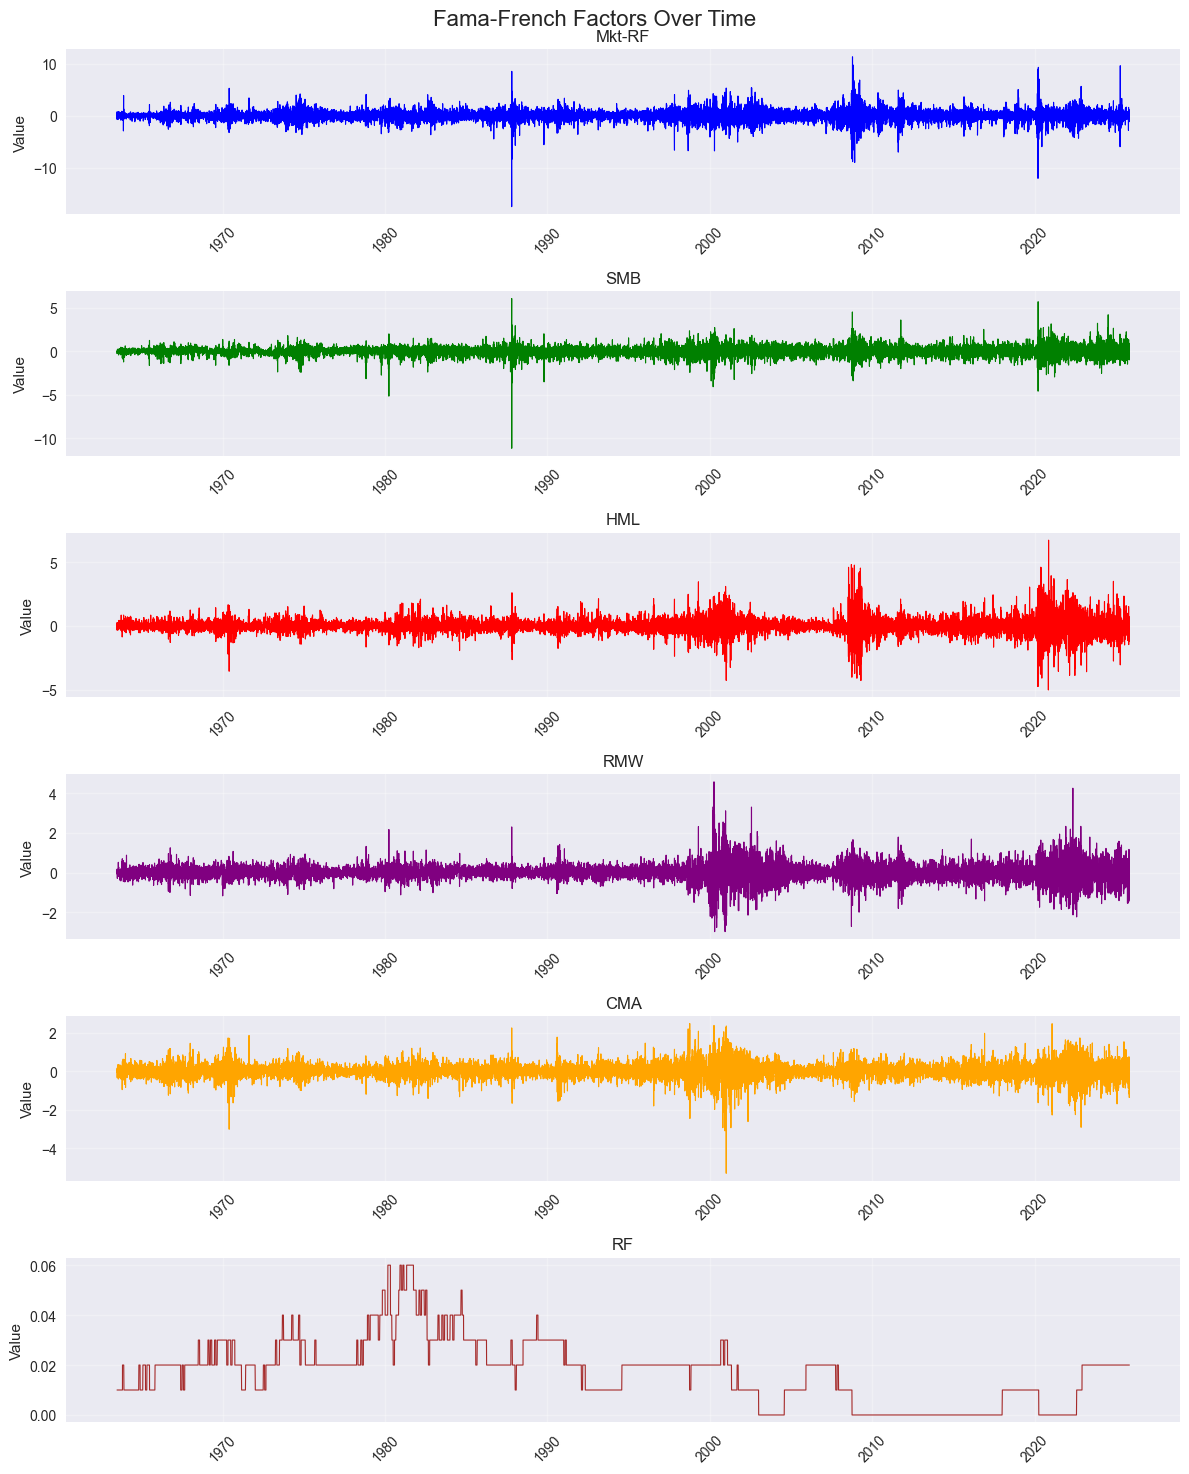

In [4]:
# Set Date as index for better plotting
ff5_data.set_index('Date', inplace=True)

# Plot each feature in subplots
features = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

fig, axes = plt.subplots(6, 1, figsize=(12, 15))
fig.suptitle('Fama-French Factors Over Time', fontsize=16)

for i, (feature, color) in enumerate(zip(features, colors)):
    axes[i].plot(ff5_data.index, ff5_data[feature], color=color, linewidth=0.8)
    axes[i].set_title(f'{feature}', fontsize=12)
    axes[i].set_ylabel('Value')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Figure 1: Time-series plot of Fama–French Five Factors over time.**

### 3.2 Temporal Patterns

Time-series plots show clear volatility clustering during major economic events, including the 2008 Global Financial Crisis and the 2020 COVID-19 market crash.

## 3. Exploratory Data Analysis

Exploratory analysis is conducted to understand the statistical properties of the factor data and to motivate model selection.

### 3.1 Summary Statistics

Descriptive statistics reveal that the market excess return (Mkt-RF) exhibits the highest volatility, reflecting its sensitivity to macroeconomic shocks. In contrast, the risk-free rate remains comparatively stable.

Let's compute and display the summary statistics for the FF5 factors.

### Download current S&P 500 constituents and compute monthly returns (including SPY benchmark)

In [5]:
sp500_csv_path = "data/raw/sp500.csv"

if os.path.exists(sp500_csv_path):
    sp500_df = pd.read_csv(sp500_csv_path)
    if "Symbol" not in sp500_df.columns:
        raise RuntimeError("data/raw/sp500.csv is missing a 'Symbol' column.")
    sp500_df["Symbol"] = sp500_df["Symbol"].astype(str).str.replace(".", "-", regex=False)
    sp500_tickers = sp500_df["Symbol"].tolist()
else:
    if not ALLOW_DOWNLOADS:
        raise RuntimeError(
            "S&P 500 constituents file is missing and downloads are disabled. "
            "Either set USE_CACHED_DATA = False or provide data/raw/sp500.csv"
        )

    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    response = requests.get(url, headers=headers, timeout=60)
    response.raise_for_status()

    sp500_table = pd.read_html(StringIO(response.text))
    sp500_df = sp500_table[0]

    sp500_df["Symbol"] = sp500_df["Symbol"].astype(str).str.replace(".", "-", regex=False)
    sp500_df.to_csv(sp500_csv_path, index=False)

    sp500_tickers = sp500_df["Symbol"].tolist()

print("S&P 500 Companies:")
print(sp500_df.head())
print(f"\nTotal companies: {len(sp500_df)}")

S&P 500 Companies:
  Symbol             Security             GICS Sector  \
0    MMM                   3M             Industrials   
1    AOS          A. O. Smith             Industrials   
2    ABT  Abbott Laboratories             Health Care   
3   ABBV               AbbVie             Health Care   
4    ACN            Accenture  Information Technology   

                GICS Sub-Industry    Headquarters Location  Date added  \
0        Industrial Conglomerates    Saint Paul, Minnesota  1957-03-04   
1               Building Products     Milwaukee, Wisconsin  2017-07-26   
2           Health Care Equipment  North Chicago, Illinois  1957-03-04   
3                   Biotechnology  North Chicago, Illinois  2012-12-31   
4  IT Consulting & Other Services          Dublin, Ireland  2011-07-06   

       CIK      Founded  
0    66740         1902  
1    91142         1916  
2     1800         1888  
3  1551152  2013 (1888)  
4  1467373         1989  

Total companies: 503


In [6]:
sp500_df.to_csv("data/raw/sp500.csv", index=False)

In [7]:
market_csv_path = "data/raw/market_data.csv"
spy_csv_path = "data/raw/spy_monthly_returns.csv"

if os.path.exists(market_csv_path) and os.path.exists(spy_csv_path):
    monthly_returns = pd.read_csv(market_csv_path, parse_dates=["Date"]).set_index("Date")
    spy_monthly_returns = pd.read_csv(spy_csv_path, parse_dates=["Date"]).set_index("Date")["SPY"]

    monthly_returns.index = monthly_returns.index.to_period("M").to_timestamp()
    spy_monthly_returns.index = spy_monthly_returns.index.to_period("M").to_timestamp()
else:
    if not ALLOW_DOWNLOADS:
        raise RuntimeError(
            "Market/benchmark return files are missing and downloads are disabled. "
            "Either set USE_CACHED_DATA = False or provide data/raw/market_data.csv and data/raw/spy_monthly_returns.csv"
        )

    # Download monthly data with proper parameters
    start_date = "2005-01-01"
    end_date = datetime.now().strftime("%Y-%m-%d")

    print("=" * 60)
    print("DOWNLOADING S&P 500 DATA")
    print("=" * 60)

    # Download SPY benchmark data - monthly
    print("\n[1/2] Downloading SPY (Benchmark)...")
    spy_data = yf.download(
        tickers="SPY",
        start=start_date,
        end=end_date,
        interval="1mo",
        progress=True,
        auto_adjust=True,
    )

    # Download all S&P 500 stocks - monthly
    print("\n[2/2] Downloading all S&P 500 stocks...")
    price_data = yf.download(
        tickers=sp500_tickers,
        start=start_date,
        end=end_date,
        interval="1mo",
        threads=True,
        progress=True,
        auto_adjust=True,
        group_by="column",
    )

    # Calculate monthly returns (with auto_adjust=True, use 'Close' not 'Adj Close')
    monthly_returns = price_data["Close"].pct_change(fill_method=None)
    spy_monthly_returns = spy_data["Close"].pct_change(fill_method=None)

    # Standardize monthly timestamps to month-start and drop the current (incomplete) month if present
    monthly_returns.index = monthly_returns.index.to_period("M").to_timestamp()
    spy_monthly_returns.index = spy_monthly_returns.index.to_period("M").to_timestamp()

    current_month = pd.Timestamp.today().to_period("M")
    if len(monthly_returns) > 0 and monthly_returns.index.max().to_period("M") == current_month:
        monthly_returns = monthly_returns.iloc[:-1]
    if len(spy_monthly_returns) > 0 and spy_monthly_returns.index.max().to_period("M") == current_month:
        spy_monthly_returns = spy_monthly_returns.iloc[:-1]

    print("\n" + "=" * 60)
    print("DOWNLOAD SUMMARY")
    print("=" * 60)
    print(f" Price data shape: {price_data.shape}")
    print(f"Monthly returns shape: {monthly_returns.shape}")
    print(f"Date range: {monthly_returns.index[0].strftime('%Y-%m-%d')} to {monthly_returns.index[-1].strftime('%Y-%m-%d')}")
    print(f"Total months: {len(monthly_returns)}")
    print(f"Successfully downloaded: {monthly_returns.shape[1]} stocks")
    print("=" * 60)

In [8]:
monthly_returns

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2005-02-01,0.085482,0.166710,NaN,NaN,0.027219,0.129322,-0.019194,0.085237,0.023127,-0.004132,...,0.072596,0.091672,-0.025838,0.226938,NaN,NaN,0.054695,0.089410,-0.020813,NaN
2005-03-01,-0.075000,-0.071111,NaN,NaN,0.013699,-0.034716,-0.054794,0.087773,-0.014175,0.023453,...,0.030018,-0.053514,-0.030475,-0.053990,NaN,NaN,0.062116,-0.094179,-0.047724,NaN
2005-04-01,-0.065316,-0.134629,NaN,NaN,0.054482,-0.001249,-0.101449,-0.114461,-0.056170,-0.268104,...,0.001606,-0.218482,0.012446,-0.043121,NaN,NaN,-0.093611,0.046396,0.005685,NaN
2005-05-01,0.157109,0.102606,NaN,NaN,-0.013048,0.116529,0.072811,0.113839,0.087071,0.103392,...,-0.065005,-0.115036,0.072760,-0.014554,NaN,NaN,0.094341,-0.059445,-0.108878,NaN
2005-06-01,-0.041232,-0.074195,NaN,NaN,0.015962,0.008959,-0.026203,-0.136171,0.008941,0.081786,...,-0.000419,0.008965,0.059143,0.027806,NaN,NaN,0.015402,-0.005354,0.028900,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-01,-0.027116,0.011698,0.018317,0.000529,-0.072201,-0.054805,-0.106360,-0.075450,-0.051959,0.026525,...,-0.024912,0.163980,0.087388,0.035622,0.117965,0.137347,-0.027197,0.007430,0.099429,-0.065149
2025-08-01,0.096809,0.118370,0.122724,-0.014198,0.055991,0.063560,-0.021826,-0.002768,0.118773,0.156146,...,0.032735,0.162524,-0.014297,0.023737,-0.021159,0.030805,0.019563,0.157665,-0.064686,0.076363
2025-09-01,0.021407,0.098126,0.100475,-0.069792,0.009649,-0.008740,-0.051429,-0.011074,-0.022323,-0.038115,...,-0.033929,0.014309,0.114104,-0.004294,0.044851,-0.092541,0.034225,-0.071631,-0.062853,-0.064450


In [9]:
spy_monthly_returns

Date
2005-02-01    0.020904
2005-03-01   -0.022134
2005-04-01   -0.014880
2005-05-01    0.032224
2005-06-01   -0.002511
                ...   
2025-07-01    0.026056
2025-08-01    0.020520
2025-09-01    0.032757
2025-10-01    0.026676
2025-11-01    0.001950
Freq: MS, Name: SPY, Length: 250, dtype: float64

In [10]:
# Save data as csv files
# Drop the first month created by pct_change() (typically all-NaN / NaN)

market_csv_path = "data/raw/market_data.csv"
spy_csv_path = "data/raw/spy_monthly_returns.csv"

if not (os.path.exists(market_csv_path) and os.path.exists(spy_csv_path)):
    monthly_returns_to_save = monthly_returns.dropna(how="all")
    monthly_returns_to_save.index.name = "Date"
    monthly_returns_to_save.to_csv(market_csv_path, index=True)

    # Ensure the benchmark CSV has a consistent column name: SPY
    if isinstance(spy_monthly_returns, pd.Series):
        spy_to_save = spy_monthly_returns.rename("SPY").to_frame()
    else:
        spy_to_save = spy_monthly_returns.copy()
        if list(spy_to_save.columns) != ["SPY"] and spy_to_save.shape[1] == 1:
            spy_to_save.columns = ["SPY"]

    # Drop the first NaN return from pct_change()
    spy_to_save = spy_to_save.dropna()
    spy_to_save.index.name = "Date"
    spy_to_save.to_csv(spy_csv_path, index=True)

print("Saved/using cached files:")
print(" -", market_csv_path)
print(" -", spy_csv_path)

Saved/using cached files:
 - data/raw/market_data.csv
 - data/raw/spy_monthly_returns.csv


In [11]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [12]:
ff5_data = pd.read_csv('data/raw/ff5_data.csv')
ff5_data['Date'] = pd.to_datetime(ff5_data['Date'].astype(str), format='%Y%m%d', errors='coerce')
ff5_data = ff5_data.dropna(subset=['Date']).set_index('Date').sort_index()
ff5_data = ff5_data / 100.0

spy_returns = pd.read_csv('data/raw/spy_monthly_returns.csv', index_col=0)
spy_returns.index = pd.to_datetime(spy_returns.index, errors='coerce')
spy_returns = spy_returns[spy_returns.index.notna()]
spy_returns = spy_returns.rename(columns={'SPY': 'SPY_returns'})

sp500_returns = pd.read_csv('data/raw/market_data.csv', index_col=0)
sp500_returns.index = pd.to_datetime(sp500_returns.index, errors='coerce')
sp500_returns = sp500_returns[sp500_returns.index.notna()]

print("Data loaded successfully!")
print(f"FF5 data: {ff5_data.shape}")
print(f"SPY returns: {spy_returns.shape}")
print(f"SP500 returns: {sp500_returns.shape}")

Data loaded successfully!
FF5 data: (15690, 6)
SPY returns: (250, 1)
SP500 returns: (250, 503)


#### Fama-French 5 Factors 

**Mkt-RF (Market Risk Premium)**  
Market return minus risk-free rate. Measures if stocks beat safe investments.

**SMB (Small Minus Big)**  
Small-cap vs large-cap performance. Captures size effect.

**HML (High Minus Low)**  
Value stocks vs growth stocks. The "value premium."

**RMW (Robust Minus Weak)**  
Profitable vs unprofitable companies. Quality factor.

**CMA (Conservative Minus Aggressive)**  
Conservative vs aggressive investors. Investment discipline factor.

**RF (Risk-Free Rate)**  
Return on safe investments (T-bills). Baseline return.


##### Interpreting Positive vs Negative Values

| Factor | Positive Means | Negative Means |
|--------|---------------|----------------|
| **Mkt-RF** | Stocks beat bonds | Bonds beat stocks |
| **SMB** | Small caps win | Large caps win |
| **HML** | Value stocks win | Growth stocks win |
| **RMW** | Profitable firms win | Unprofitable firms win |
| **CMA** | Conservative wins | Aggressive wins |
| **RF** | Higher safe returns | Lower safe returns |

### Data Exploration

In [13]:
# limit data to understandable range
ff5_recent = ff5_data.loc['2005-01-01':]
print(f"Data range: {ff5_recent.index[0]} to {ff5_recent.index[-1]}")
print(f"Shape: {ff5_recent.shape}")
print("\nFirst 10 rows:")
print(ff5_recent.head(10))

Data range: 2005-01-03 00:00:00 to 2025-10-31 00:00:00
Shape: (5242, 6)

First 10 rows:
            Mkt-RF     SMB     HML     RMW     CMA      RF
Date                                                      
2005-01-03 -0.0097 -0.0063 -0.0005  0.0035 -0.0001  0.0001
2005-01-04 -0.0130 -0.0051  0.0044  0.0083 -0.0048  0.0001
2005-01-05 -0.0051 -0.0114  0.0002  0.0004 -0.0013  0.0001
2005-01-06  0.0034 -0.0003  0.0013  0.0052 -0.0012  0.0001
2005-01-07 -0.0022 -0.0084 -0.0010 -0.0015 -0.0002  0.0001
2005-01-10  0.0042  0.0029  0.0012  0.0000 -0.0023  0.0001
2005-01-11 -0.0068 -0.0029  0.0037  0.0088 -0.0017  0.0001
2005-01-12  0.0038 -0.0009 -0.0009 -0.0022  0.0012  0.0001
2005-01-13 -0.0077  0.0024  0.0039  0.0005  0.0001  0.0001
2005-01-14  0.0066  0.0050  0.0004 -0.0019  0.0015  0.0001


In [14]:
# 3.2 Main characteristics of data
print("\n=== SUMMARY STATISTICS ===")
print(ff5_recent.describe())

print("\n=== DATA TYPES ===")
print(ff5_recent.dtypes)

print("\n=== MISSING VALUES ===")
missing = ff5_recent.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values")

# Drop rows with missing values
ff5_recent = ff5_recent.dropna()

# Convert index to datetime if not already
ff5_recent.index = pd.to_datetime(ff5_recent.index)

# Convert daily factor data to monthly data.
# RF is a daily simple rate; we compound it to get monthly RF.
rf_monthly = (1 + ff5_recent['RF']).resample('M').prod() - 1

# Mkt-RF is an excess return. To aggregate correctly, build the market total return first,
# then subtract the compounded monthly RF.
mkt_total_daily = ff5_recent['Mkt-RF'] + ff5_recent['RF']
mkt_total_monthly = (1 + mkt_total_daily).resample('M').prod() - 1
mkt_rf_monthly = mkt_total_monthly - rf_monthly

# Style factors are long/short portfolio returns; we compound within the month.
other_factors = ['SMB', 'HML', 'RMW', 'CMA']
other_monthly = (1 + ff5_recent[other_factors]).resample('M').prod() - 1

ff5_monthly = pd.concat(
    [mkt_rf_monthly.rename('Mkt-RF'), other_monthly, rf_monthly.rename('RF')],
    axis=1
)

# Align to month-start timestamps (matches SPY monthly return index)
ff5_monthly.index = ff5_monthly.index.to_period('M').to_timestamp()


=== SUMMARY STATISTICS ===
            Mkt-RF          SMB          HML          RMW          CMA  \
count  5242.000000  5242.000000  5242.000000  5242.000000  5242.000000   
mean      0.000421    -0.000024    -0.000034     0.000125    -0.000008   
std       0.012247     0.006396     0.007982     0.004586     0.003946   
min      -0.120100    -0.045800    -0.050300    -0.027100    -0.029200   
25%      -0.004300    -0.003700    -0.003500    -0.002400    -0.002000   
50%       0.000700    -0.000100    -0.000200     0.000100    -0.000100   
75%       0.006000     0.003500     0.003200     0.002500     0.001900   
max       0.113600     0.057100     0.067300     0.042500     0.024700   

                RF  
count  5242.000000  
mean      0.000067  
std       0.000083  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000100  
max       0.000200  

=== DATA TYPES ===
Mkt-RF    float64
SMB       float64
HML       float64
RMW       float64
CMA       float64
RF    

In [15]:
ff5_monthly

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2005-01-01,-0.027735,-0.011014,0.021046,0.028971,-0.014525,0.002002
2005-02-01,0.018765,-0.002827,0.014022,0.012924,-0.002025,0.001902
2005-03-01,-0.019641,-0.014406,0.021232,0.004640,0.013652,0.002202
2005-04-01,-0.026120,-0.040480,0.000432,0.009965,-0.009089,0.002102
2005-05-01,0.036674,0.027503,-0.005475,-0.009930,0.002468,0.002102
...,...,...,...,...,...,...
2025-06-01,0.048675,0.000082,-0.015139,-0.029946,0.013773,0.004008
2025-07-01,0.019862,-0.000945,-0.012762,-0.003399,-0.020352,0.004409
2025-08-01,0.018490,0.048683,0.042643,-0.006815,0.019643,0.004208


#### Plot FF factors with historical context

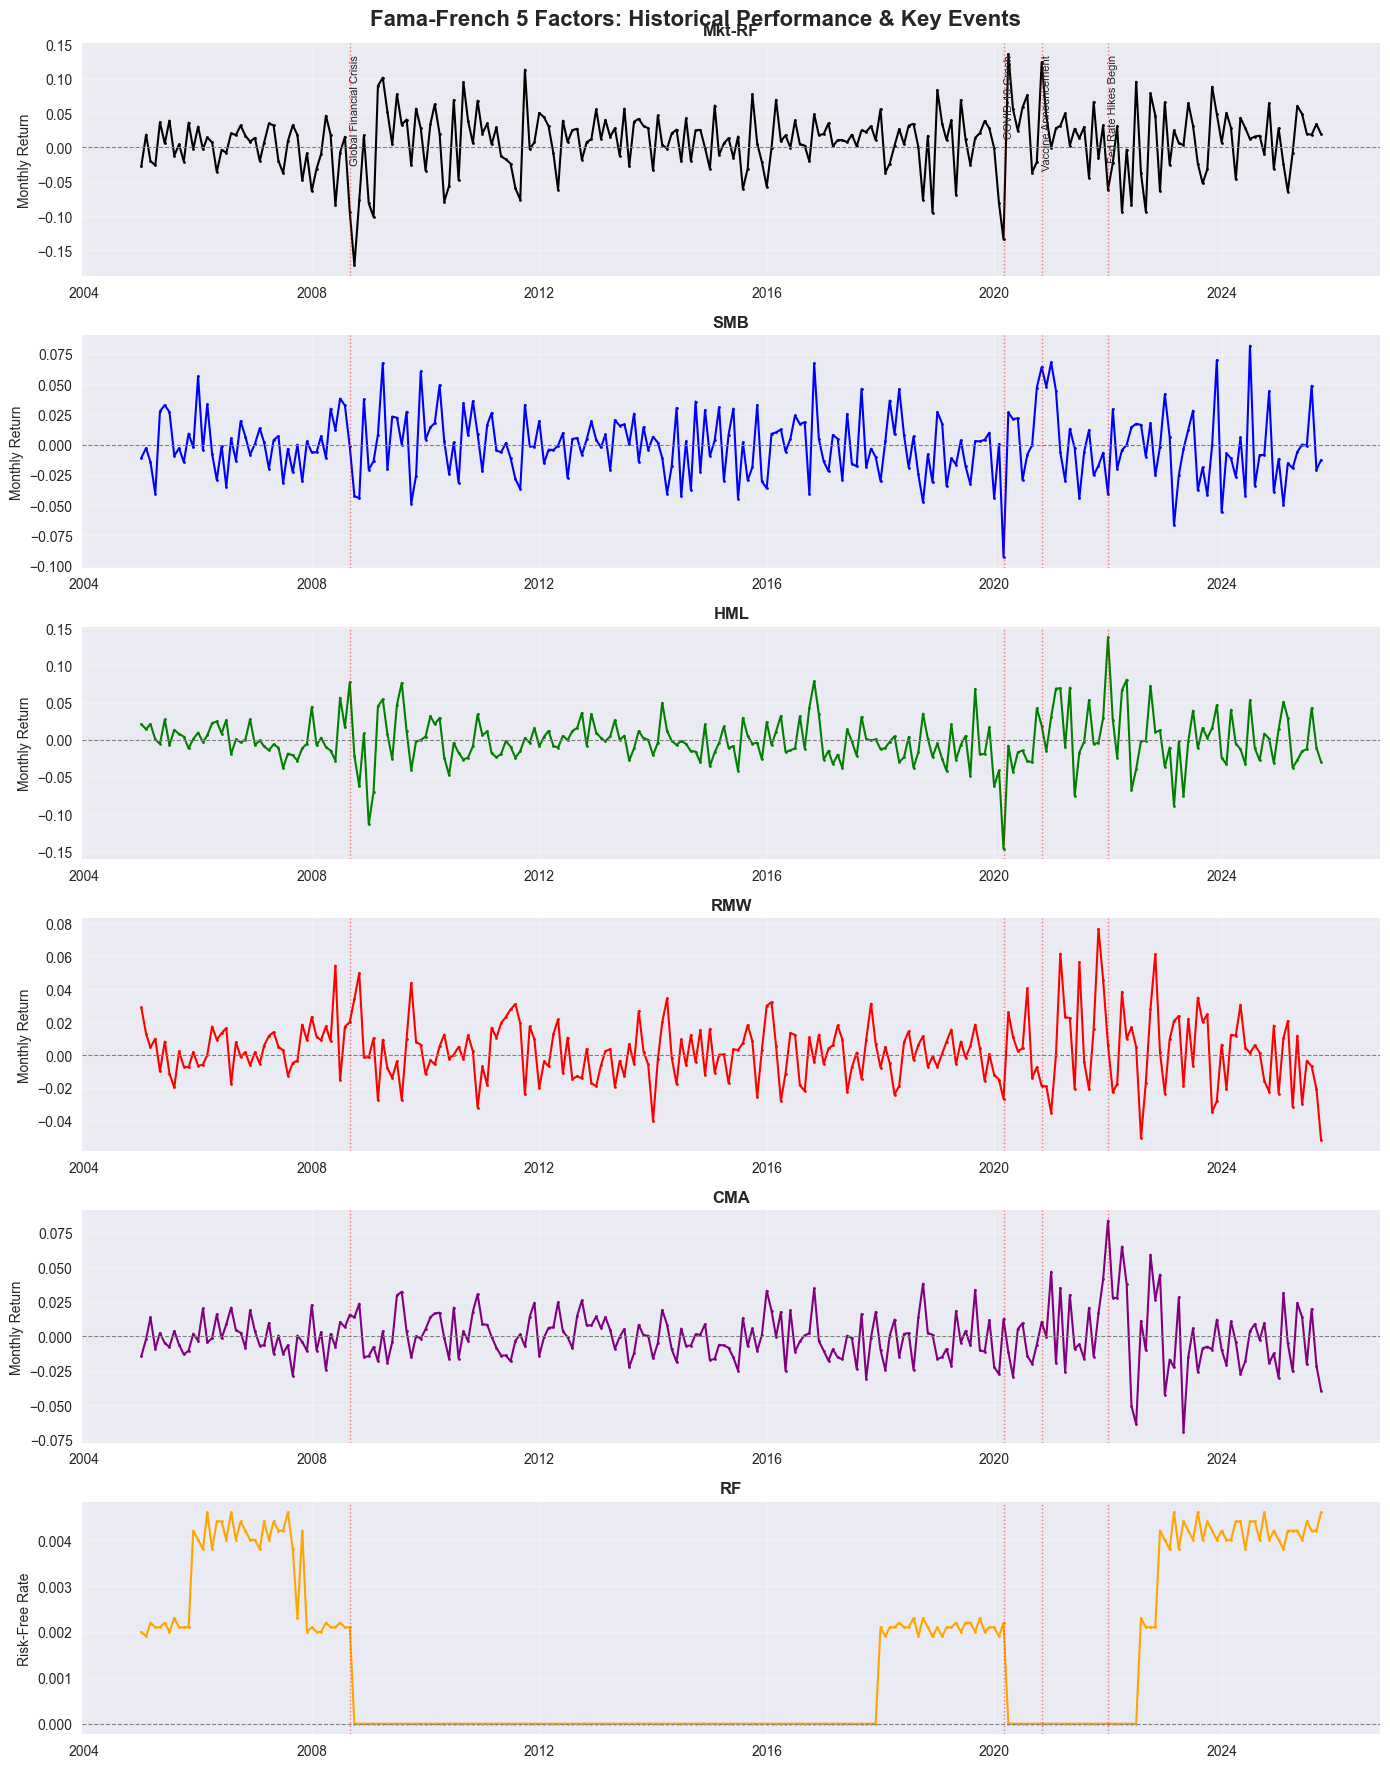

Original data points: 5242
Monthly sampled points: 250


In [16]:
fig, axes = plt.subplots(6, 1, figsize=(14, 18))
fig.suptitle('Fama-French 5 Factors: Historical Performance & Key Events', 
             fontsize=16, fontweight='bold')

factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
colors = ['black', 'blue', 'green', 'red', 'purple', 'orange']

# Key historical events to annotate
events = {    
    '2008-09': 'Global Financial Crisis',
    '2020-03': 'COVID-19 Crash',
    '2020-11': 'Vaccine Announcement',
    '2022-01': 'Fed Rate Hikes Begin',    
}

for i, (factor, color) in enumerate(zip(factors, colors)):
    # Plot the time series
    axes[i].plot(ff5_monthly.index, ff5_monthly[factor], color=color, linewidth=1.5, marker='o', markersize=2)
    axes[i].set_title(f'{factor}', fontsize=12, fontweight='bold')
    
    # Better y-axis label based on what FF data actually is
    if factor == 'RF':
        axes[i].set_ylabel('Risk-Free Rate', fontsize=10)
    else:
        axes[i].set_ylabel('Monthly Return', fontsize=10)
    
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    
    # Add event annotations
    for date, event in events.items():
        event_date = pd.to_datetime(date)
        if event_date >= ff5_monthly.index.min() and event_date <= ff5_monthly.index.max():
            axes[i].axvline(x=event_date, color='red', 
                          linestyle=':', alpha=0.5, linewidth=1)
            # Add text label only on first subplot
            if i == 0:
                axes[i].text(event_date, axes[i].get_ylim()[1]*0.9, event, 
                           rotation=90, verticalalignment='top', fontsize=8)

plt.tight_layout()
plt.show()

print(f"Original data points: {len(ff5_recent)}")
print(f"Monthly sampled points: {len(ff5_monthly)}")

#### Statistical Method #1 – Distribution & Summary Statistics

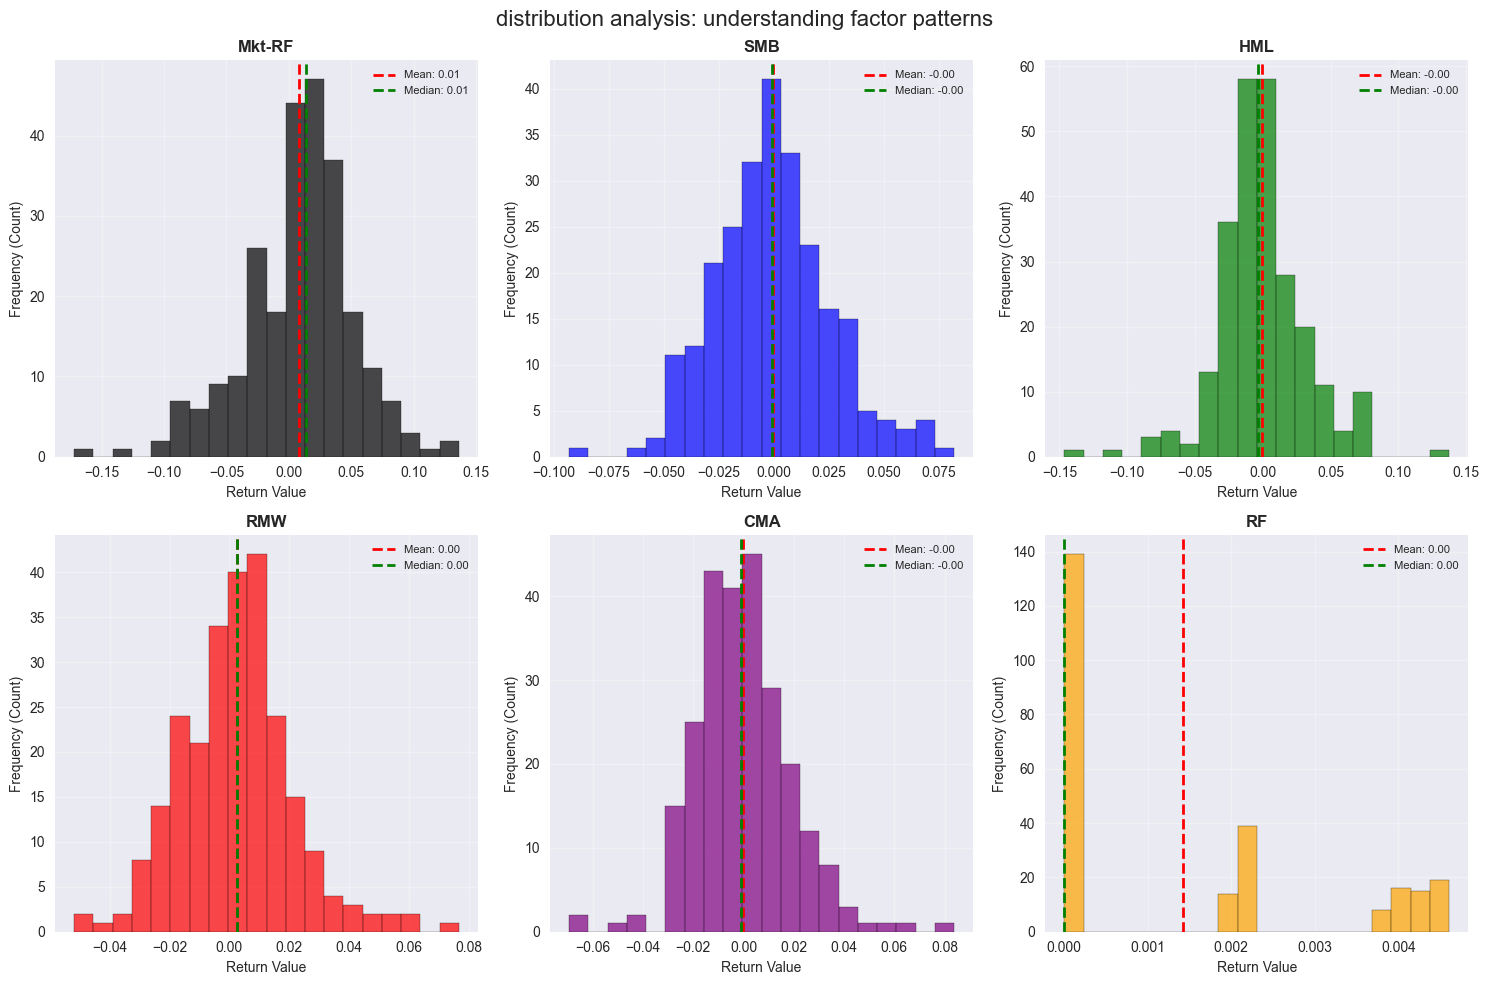

In [17]:

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('distribution analysis: understanding factor patterns', fontsize=16)

axes = axes.flatten()
for i, factor in enumerate(factors):
    # Simple histogram
    axes[i].hist(ff5_monthly[factor], bins=20, alpha=0.7, color=colors[i], edgecolor='black')
    
    # Add mean line
    mean_val = ff5_monthly[factor].mean()
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    
    # Add median line
    median_val = ff5_monthly[factor].median()
    axes[i].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    
    axes[i].set_title(f'{factor}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Return Value', fontsize=10)
    axes[i].set_ylabel('Frequency (Count)', fontsize=10)
    axes[i].legend(fontsize=8)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# statistics
print("\n=== STATISTICS FOR EACH FACTOR ===\n")
for factor in factors:
    print(f"{factor}:")
    print(f"  Mean (Average):     {ff5_monthly[factor].mean():.4f}")
    print(f"  Median (Middle):    {ff5_monthly[factor].median():.4f}")
    print(f"  Std Dev (Spread):   {ff5_monthly[factor].std():.4f}")
    print()

# check for symmetry 
print("\n=== IS THE DATA BALANCED? ===\n")
for factor in factors:
    mean_val = ff5_monthly[factor].mean()
    median_val = ff5_monthly[factor].median()
    std_dev = ff5_monthly[factor].std()
    
    if abs(mean_val - median_val) < 0.1 * std_dev:
        balance = " Balanced (mean ≈ median)"
    elif mean_val > median_val:
        balance = " Right-skewed (more extreme positive values)"
    else:
        balance = " Left-skewed (more extreme negative values)"
    
    print(f"{factor}: {balance}")


=== STATISTICS FOR EACH FACTOR ===

Mkt-RF:
  Mean (Average):     0.0083
  Median (Middle):    0.0135
  Std Dev (Spread):   0.0444

SMB:
  Mean (Average):     -0.0006
  Median (Middle):    -0.0009
  Std Dev (Spread):   0.0266

HML:
  Mean (Average):     -0.0008
  Median (Middle):    -0.0033
  Std Dev (Spread):   0.0323

RMW:
  Mean (Average):     0.0026
  Median (Middle):    0.0026
  Std Dev (Spread):   0.0190

CMA:
  Mean (Average):     -0.0002
  Median (Middle):    -0.0010
  Std Dev (Spread):   0.0192

RF:
  Mean (Average):     0.0014
  Median (Middle):    0.0000
  Std Dev (Spread):   0.0017


=== IS THE DATA BALANCED? ===

Mkt-RF:  Left-skewed (more extreme negative values)
SMB:  Balanced (mean ≈ median)
HML:  Balanced (mean ≈ median)
RMW:  Balanced (mean ≈ median)
CMA:  Balanced (mean ≈ median)
RF:  Right-skewed (more extreme positive values)


In [19]:
ff5_monthly[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].describe()


,Mkt-RF,SMB,HML,RMW,CMA,RF
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.008269,-0.000589,-0.000849,0.002576,-0.000159,0.001418
std,0.044389,0.026621,0.032316,0.019001,0.019188,0.001740
min,-0.172062,-0.093032,-0.146437,-0.051894,-0.069334,0.000000
25%,-0.017638,-0.018432,-0.017448,-0.007863,-0.012382,0.000000
50%,0.013542,-0.000866,-0.003298,0.002644,-0.001038,0.000000
75%,0.033872,0.014471,0.013992,0.012318,0.010395,0.002303
max,0.136169,0.081782,0.137614,0.076685,0.083789,0.004610


**Quantitative conclusion (Method #1):**

From the summary statistics and distributions:

- **Mkt-RF** is the dominant driver of variability among the factors (it has the largest spread/volatility).
- **SMB, HML, RMW, CMA** are smaller “tilt” factors that tend to be closer to zero on average and have lower volatility than the market factor.
- **RF** is comparatively small and stable.

Overall, this distribution analysis supports the intuition that the market factor explains most broad market movement, while the other FF factors provide secondary style exposures that can matter more in specific regimes.

#### Statistical Method #2 – Outliers via Boxplots + IQR Rule

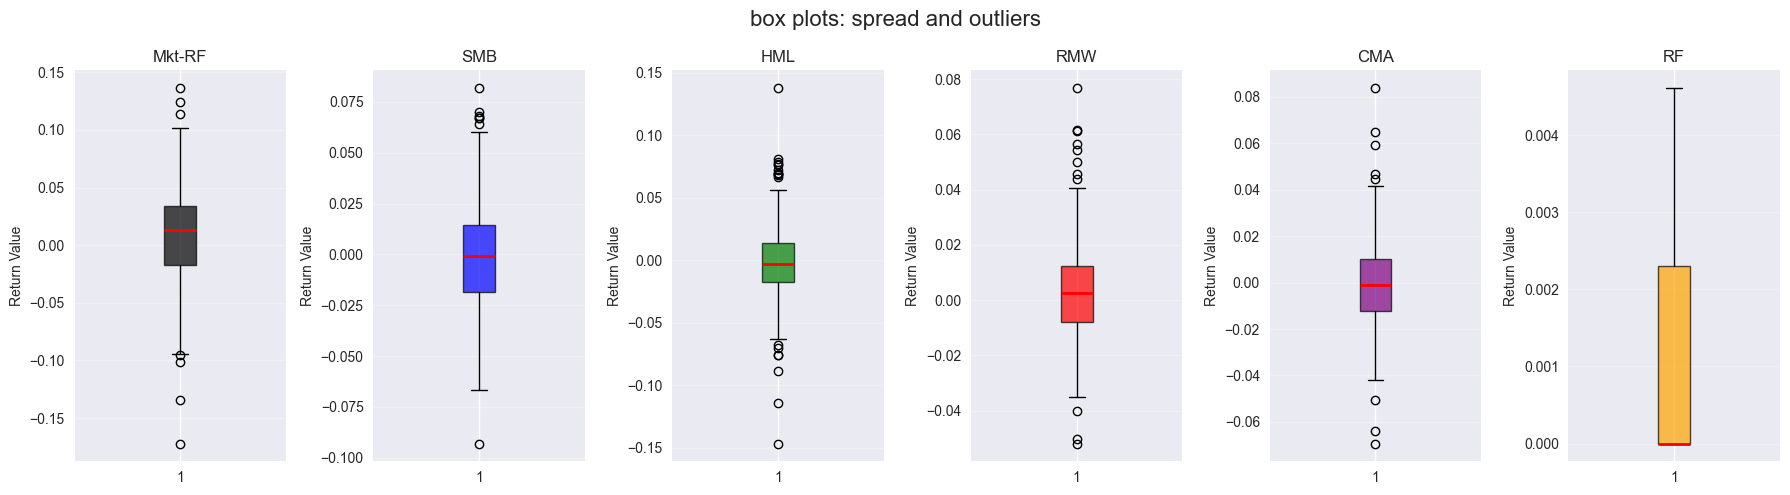

- Box: Middle 50% of data (25th to 75th percentile)
- Red line: Median (middle value)
- Whiskers: Typical range of data
- Dots: Outliers (unusual extreme values)


In [20]:

# box plots to see spread and outliers
fig, axes = plt.subplots(1, 6, figsize=(18, 5))
fig.suptitle('box plots: spread and outliers', fontsize=16)

for i, factor in enumerate(factors):
    axes[i].boxplot(ff5_monthly[factor], patch_artist=True,
                   boxprops=dict(facecolor=colors[i], alpha=0.7),
                   medianprops=dict(color='red', linewidth=2))
    axes[i].set_title(factor, fontsize=12)
    axes[i].set_ylabel('Return Value', fontsize=10)
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("- Box: Middle 50% of data (25th to 75th percentile)")
print("- Red line: Median (middle value)")
print("- Whiskers: Typical range of data")
print("- Dots: Outliers (unusual extreme values)")

**Figure 3: Histograms and boxplots of FF5 factors.**

### 3.4 Correlation Analysis

Correlation analysis between FF5 factors and S&P 500 monthly returns shows that Mkt-RF has the strongest positive correlation, while other factors exhibit weaker but economically meaningful relationships.

Let's compute and visualize the correlations.

In [ ]:
# Compute correlation matrix between FF5 factors and S&P 500 returns
# First, we need to align the data
# Assuming ff5_monthly and spy_monthly_returns are available

# For simplicity, let's compute correlations between factors
correlation_matrix = ff5_monthly[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap of Fama-French Five Factors')
plt.show()

**Figure 4: Correlation heatmap between FF5 factors and S&P 500 returns.**

## 4. Models and Methodology

### 4.1 SPY Benchmark

SPY serves as the baseline strategy, representing passive exposure to market returns. All model performance is evaluated relative to this benchmark.

### 4.2 Linear Fama–French Model

A rolling-window linear regression is used to estimate time-varying factor loadings. This approach allows factor sensitivities to evolve with changing market conditions and provides interpretable coefficients grounded in financial theory.

### 4.3 XGBoost Model

XGBoost is employed to capture nonlinear relationships and interactions among factors. While less interpretable, this model offers greater flexibility and the potential to improve predictive accuracy during complex market regimes.

### 4.4 Backtesting Framework

All models are evaluated using a walk-forward backtesting approach. Training occurs on historical windows, and predictions are generated for unseen future periods to prevent look-ahead bias.

**Figure 5: Diagram illustrating rolling training and walk-forward prediction pipeline.**

Now, let's implement these models.

In [21]:
# Outlier detection using IQR rule
outlier_counts = {}

print("=== OUTLIER COUNTS USING IQR RULE ===")
for factor in factors:
    q1 = ff5_monthly[factor].quantile(0.25)
    q3 = ff5_monthly[factor].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    mask = (ff5_monthly[factor] < lower) | (ff5_monthly[factor] > upper)
    count = mask.sum()
    outlier_counts[factor] = count

    print(f"{factor}: {count} outliers "
          f"(lower={lower:.4f}, upper={upper:.4f})")

=== OUTLIER COUNTS USING IQR RULE ===
Mkt-RF: 7 outliers (lower=-0.0949, upper=0.1111)
SMB: 7 outliers (lower=-0.0678, upper=0.0638)
HML: 18 outliers (lower=-0.0646, upper=0.0612)
RMW: 11 outliers (lower=-0.0381, upper=0.0426)
CMA: 8 outliers (lower=-0.0465, upper=0.0446)
RF: 0 outliers (lower=-0.0035, upper=0.0058)


**Outlier rule and policy (Method #2):**

- We define outliers using the standard IQR rule: any value below Q1 − 1.5·IQR or above Q3 + 1.5·IQR.
- Each factor has only a small number of outliers relative to the total number of months, and these points correspond to real market stress periods (e.g., crises, crashes).
- Because we want our model to capture real extreme events, we **keep** these outliers in the dataset instead of removing or winsorizing them. We will, however, check model diagnostics later to ensure they don’t completely dominate the regression.

#### Statistical Method #3 – Correlation & Hypothesis Test (SPY vs FF5 Factors)

We align data to a monthly frequency (by compounding daily data within each month). Because `Mkt-RF` is defined as an **excess return**, we compare **SPY excess returns (SPY − RF)** to the FF5 factors at a monthly frequency.

**Notes for reproducibility / interpretation:**

- All returns/factors are in **decimal form** (e.g., 0.02 = 2%).
- FF5 data availability can lag the latest market month; we use an **inner join** so this analysis uses only months present in both datasets.


=== HOW RELATED ARE FACTORS TO SPY? (MONTHLY, EXCESS-RETURN ALIGNED) ===
Correlation ranges from -1 to +1:
  +1 = Perfect positive relationship (move together)
   0 = No relationship
  -1 = Perfect negative relationship (move opposite)

Mkt-RF    0.990466
SMB       0.304479
HML       0.138649
RF       -0.057112
CMA      -0.113793
RMW      -0.147610
Name: SPY_excess, dtype: float64


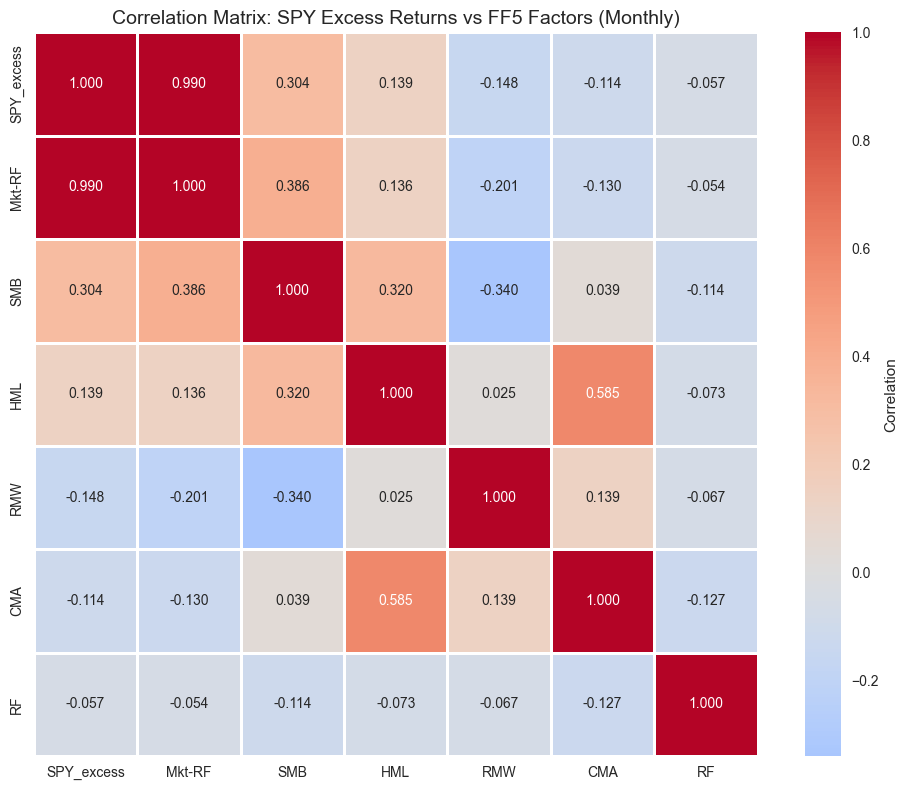


=== WHAT DOES THIS MEAN? ===
Strongest relationship: Mkt-RF (correlation = 0.990)
This factor moves most closely with SPY excess returns

Weakest relationship: RF (correlation = -0.057)
This factor has little connection to SPY excess returns


In [22]:
combined = pd.DataFrame(spy_returns)
combined = combined.join(ff5_monthly[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']], how='inner')

# Use SPY excess returns to match the definition of Mkt-RF (market excess return)
combined['SPY_excess'] = combined['SPY_returns'] - combined['RF']

print("\n=== HOW RELATED ARE FACTORS TO SPY? (MONTHLY, EXCESS-RETURN ALIGNED) ===")
print("Correlation ranges from -1 to +1:")
print("  +1 = Perfect positive relationship (move together)")
print("   0 = No relationship")
print("  -1 = Perfect negative relationship (move opposite)\n")

correlations = combined.corr()['SPY_excess'].drop(['SPY_returns', 'SPY_excess']).sort_values(ascending=False)
print(correlations)

plt.figure(figsize=(10, 8))
cols = ['SPY_excess', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
sns.heatmap(combined[cols].corr(), annot=True, cmap='coolwarm', center=0,
            fmt='.3f', square=True, linewidths=1, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix: SPY Excess Returns vs FF5 Factors (Monthly)', fontsize=14)
plt.tight_layout()
plt.show()

print("\n=== WHAT DOES THIS MEAN? ===")
strongest = correlations.abs().idxmax()
print(f"Strongest relationship: {strongest} (correlation = {correlations[strongest]:.3f})")
print("This factor moves most closely with SPY excess returns")

weakest = correlations.abs().idxmin()
print(f"\nWeakest relationship: {weakest} (correlation = {correlations[weakest]:.3f})")
print("This factor has little connection to SPY excess returns")

##### Key Learnings from Correlation Analysis

- The factor with the largest absolute correlation (printed above) is the one most closely related to **SPY excess returns** in this sample.
- In practice, **Mkt-RF** is typically expected to be the dominant driver because SPY closely tracks the broad market.
- The remaining factors (SMB/HML/RMW/CMA) are style tilts and can be weaker or regime-dependent.
- **RF** often shows a weak relationship with equity **excess** returns (and we already subtract RF when forming SPY excess returns).

Use the printed correlation values and heatmap above for the exact magnitudes in this run.

#### Formal hypothesis test on correlation (Method #3)

- H₀ (null): true correlation between **SPY excess returns** and **Mkt-RF** is 0.
- H₁ (alternative): true correlation is not 0.
- α = 0.05, Pearson correlation test.

In [23]:
valid = combined[['SPY_excess', 'Mkt-RF']].dropna()

r, p_value = pearsonr(valid['SPY_excess'], valid['Mkt-RF'])

print("=== PEARSON CORRELATION TEST: SPY Excess vs Mkt-RF ===")
print(f"Correlation coefficient (r): {r:.3f}")
print(f"p-value: {p_value:.4g}")

=== PEARSON CORRELATION TEST: SPY Excess vs Mkt-RF ===
Correlation coefficient (r): 0.990
p-value: 1.172e-214


**Hypothesis test result (Method #3):**

Use the printed values above:
- `r` is the sample correlation between monthly **SPY excess returns** and monthly `Mkt-RF`.
- `p-value` determines statistical significance.

Decision rule at α = 0.05:
- If `p-value < 0.05`, reject H₀ (evidence correlation is not zero).
- If `p-value >= 0.05`, do not reject H₀.

In either case, `Mkt-RF` remains an economically important factor in the Fama-French framework; this test only evaluates linear correlation in this sample.

# Factor-Based Stock Selection vs the S&P 500 (FF5 Rolling Strategy + ML Ranking)

## Notebook flow (baseline + two-model comparison)

This notebook contains:

1. **A transparent baseline strategy** using rolling FF5 betas to form a monthly top‑50 portfolio.
2. A **two-model machine learning comparison** (the part you “tried two models and chose one”):
   - **Model 1:** Linear model (Logistic Regression)
   - **Model 2:** XGBoost learning-to-rank

Both ML models are trained and evaluated walk-forward (no look-ahead), and the final section compares the two models against **SPY**.

### Sections

1. **Setup** (imports + helper functions)
2. **Data preparation**
   - FF5 daily → monthly (compounded)
   - Load S&P 500 monthly returns
   - Merge + excess returns
3. **Baseline factor strategy** (rolling FF5 betas → signal → top‑50 portfolio)
4. **Backtest & benchmarking** (baseline vs SPY)
5. **Two-model ML comparison** (Linear vs XGBoost)
6. **Final conclusion** (choose the better-performing model)

Run the notebook top-to-bottom (Kernel: Restart & Run All) to reproduce results and regenerate figures in `docs/assets/`.

### 1. Import Libraries

We import the core Python libraries needed for this project:
- **pandas** for data loading and cleaning  
- **numpy** for numerical regression  
- **matplotlib** for visualization  
- set the global plotting style for consistency


In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

plt.style.use("seaborn-v0_8")

# Ensure docs assets folder exists for GitHub Pages figures
os.makedirs("docs/assets", exist_ok=True)

# XGBoost (Model 2 learning-to-rank)
try:
    from xgboost import XGBRanker
    _HAS_XGBOOST = True
except Exception:
    XGBRanker = None
    _HAS_XGBOOST = False

## Part 0. Setup Helpers

This section defines the small helper functions used throughout the notebook (OLS and rolling FF5 regression). Defining them up front makes the execution flow easier to follow.

In [25]:
def ols_numpy(X, y):
    """Perform closed-form OLS regression."""
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    return beta


In [26]:
def rolling_factor_loadings(df, ticker, window=36, min_obs=24):
    betas = []
    dates = []

    y_all = df[ticker].astype(float).values
    X_all = df[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]].astype(float).values
    X_all = np.column_stack([np.ones(len(X_all)), X_all])

    for i in range(window, len(df)):
        y = y_all[i - window:i]
        X = X_all[i - window:i]

        mask = np.isfinite(y) & np.all(np.isfinite(X), axis=1)
        if mask.sum() < min_obs:
            continue

        beta = ols_numpy(X[mask], y[mask])
        betas.append(beta)
        dates.append(df["date"].iloc[i])

    if len(betas) == 0:
        return pd.DataFrame(columns=["alpha", "MKT", "SMB", "HML", "RMW", "CMA"])

    return pd.DataFrame(
        betas,
        index=dates,
        columns=["alpha", "MKT", "SMB", "HML", "RMW", "CMA"],
    )


## Part I. Baseline Strategy (Rolling FF5 Betas → Signal → Top-50 Portfolio)

This part builds a transparent walk-forward factor strategy:
- Estimate rolling 36-month FF5 betas per stock (on excess returns)
- Forecast factor returns using a lagged trailing mean (no look-ahead)
- Rank stocks each month by predicted return signal
- Form a long-only equal-weight top-50 portfolio and compare vs SPY

### 2. Load and Prepare Fama–French 5-Factor Data

The FF5 dataset is provided in **daily format**, so we first:
1. Load the raw daily CSV
2. Remove footer text rows
3. Convert the date to a proper `datetime`
4. Forward-fill missing values
5. Convert from **daily → monthly** by **compounding within each month**
6. Convert the monthly dates to **month-start** to align with our market data

This ensures both datasets use the *same monthly timestamps* and that the monthly factors represent monthly returns (not a single end-of-month observation).

In [27]:
ff = pd.read_csv("data/raw/ff5_data.csv")
ff = ff[ff["Date"].astype(str).str.isdigit()].copy()
ff["date"] = pd.to_datetime(ff["Date"].astype(str), format="%Y%m%d", errors="coerce")
ff = ff.dropna(subset=["date"]).drop(columns=["Date"]).sort_values("date").reset_index(drop=True)

factor_cols = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]
ff[factor_cols] = ff[factor_cols].ffill()
ff[factor_cols] = ff[factor_cols] / 100.0

ff = ff.set_index("date")[factor_cols].sort_index()

# Monthly RF by compounding daily RF
rf_monthly = (1 + ff["RF"]).resample("M").prod() - 1

# Monthly Mkt-RF computed from compounded market total return minus compounded RF
mkt_total_daily = ff["Mkt-RF"] + ff["RF"]
mkt_total_monthly = (1 + mkt_total_daily).resample("M").prod() - 1
mkt_rf_monthly = mkt_total_monthly - rf_monthly

# Style factors compounded within the month
other_factors = ["SMB", "HML", "RMW", "CMA"]
other_monthly = (1 + ff[other_factors]).resample("M").prod() - 1

ff_monthly = pd.concat(
    [mkt_rf_monthly.rename("Mkt-RF"), other_monthly, rf_monthly.rename("RF")],
    axis=1,
)

# Align to month-start timestamps (matches market data index)
ff_monthly.index = ff_monthly.index.to_period("M").to_timestamp()
ff_monthly = ff_monthly.reset_index().rename(columns={"date": "date"})

ff_monthly.head()

,date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07-01,-0.004035,-0.004712,-0.008305,0.006493,-0.011779,0.002202
1,1963-08-01,0.050698,-0.007507,0.016490,0.003688,-0.003525,0.002202
2,1963-09-01,-0.015857,-0.004544,0.000067,-0.007802,0.001667,0.002002
3,1963-10-01,0.025157,-0.013107,-0.000324,0.027383,-0.021471,0.002303
4,1963-11-01,-0.008503,-0.009033,0.018088,-0.004348,0.022234,0.003606


### 3. Load Market Return Data (Monthly)

We load the pre-cleaned **monthly return matrix** of S&P 500 constituents.
The dataset is already in wide format (`ticker columns`), and dates are already the **first day of each month**, so minimal cleaning is needed.

In [28]:
market = pd.read_csv("data/raw/market_data.csv", parse_dates=["Date"])
market = market.rename(columns={"Date": "date"})
market = market.sort_values("date").reset_index(drop=True)

market.head()


,date,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
0,2005-02-01,0.085482,0.166710,NaN,NaN,0.027219,0.129322,-0.019194,0.085237,0.023127,...,0.072596,0.091672,-0.025838,0.226938,NaN,NaN,0.054695,0.089410,-0.020813,NaN
1,2005-03-01,-0.075000,-0.071111,NaN,NaN,0.013699,-0.034716,-0.054794,0.087773,-0.014175,...,0.030018,-0.053514,-0.030475,-0.053990,NaN,NaN,0.062116,-0.094179,-0.047724,NaN
2,2005-04-01,-0.065316,-0.134629,NaN,NaN,0.054482,-0.001249,-0.101449,-0.114461,-0.056170,...,0.001606,-0.218482,0.012446,-0.043121,NaN,NaN,-0.093611,0.046396,0.005685,NaN
3,2005-05-01,0.157109,0.102606,NaN,NaN,-0.013048,0.116529,0.072811,0.113839,0.087071,...,-0.065005,-0.115036,0.072760,-0.014554,NaN,NaN,0.094341,-0.059445,-0.108878,NaN
4,2005-06-01,-0.041232,-0.074195,NaN,NaN,0.015962,0.008959,-0.026203,-0.136171,0.008941,...,-0.000419,0.008965,0.059143,0.027806,NaN,NaN,0.015402,-0.005354,0.028900,NaN


### 4. Merge Market Returns with Factor Data

We merge the monthly market returns with the aligned monthly FF5 factors.
The merge occurs cleanly after aligning FF5 month-end dates to month-start.

We also fix column naming issues (e.g., `RF_y`) that arise from merging datasets with overlapping column names.

In [29]:
df = market.merge(ff_monthly, on="date", how="inner")

if "RF_y" in df.columns:
    df = df.rename(columns={"RF_y": "RF"})
if "RF_x" in df.columns:
    df = df.drop(columns=["RF_x"])

factor_cols = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]
tickers = [c for c in df.columns if c not in ["date"] + factor_cols]

df.head()

,date,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,YUM,ZBH,ZBRA,ZTS,Mkt-RF,SMB,HML,RMW,CMA,RF
0,2005-02-01,0.085482,0.166710,NaN,NaN,0.027219,0.129322,-0.019194,0.085237,0.023127,...,0.054695,0.089410,-0.020813,NaN,0.018765,-0.002827,0.014022,0.012924,-0.002025,0.001902
1,2005-03-01,-0.075000,-0.071111,NaN,NaN,0.013699,-0.034716,-0.054794,0.087773,-0.014175,...,0.062116,-0.094179,-0.047724,NaN,-0.019641,-0.014406,0.021232,0.004640,0.013652,0.002202
2,2005-04-01,-0.065316,-0.134629,NaN,NaN,0.054482,-0.001249,-0.101449,-0.114461,-0.056170,...,-0.093611,0.046396,0.005685,NaN,-0.026120,-0.040480,0.000432,0.009965,-0.009089,0.002102
3,2005-05-01,0.157109,0.102606,NaN,NaN,-0.013048,0.116529,0.072811,0.113839,0.087071,...,0.094341,-0.059445,-0.108878,NaN,0.036674,0.027503,-0.005475,-0.009930,0.002468,0.002102
4,2005-06-01,-0.041232,-0.074195,NaN,NaN,0.015962,0.008959,-0.026203,-0.136171,0.008941,...,0.015402,-0.005354,0.028900,NaN,0.005850,0.032672,0.027279,0.008185,-0.005022,0.002202


### 5. Compute Excess Returns for Each Stock

To prepare the regression inputs, we convert raw stock returns into **excess returns**:

\[
R_{i,t}^{excess} = R_{i,t} - RF_t
\]

This is standard in multi-factor regression based on FF5.


In [30]:
df_total = df.copy()

df_excess = df.copy()
df_excess[tickers] = df_excess[tickers].sub(df_excess["RF"], axis=0)

### 6. Ordinary Least Squares (OLS) via NumPy

The helper function `ols_numpy(...)` is defined in **Part 0**. It uses `np.linalg.lstsq` to compute OLS coefficients for the rolling regressions.

In [31]:
pass

### 7. Rolling-Window Factor Regression

The helper function `rolling_factor_loadings(...)` is defined in **Part 0**. For each stock, it fits a 36-month rolling regression of excess returns on the FF5 factors and stores the estimated betas over time.

\[
R^{excess}_{i,t} = \alpha_i + \beta_{i}^T F_t + \epsilon_t
\]

In [32]:
pass

In [33]:
len(df)

249

### 8. Run Rolling-Window Regressions Across All S&P 500 Tickers

We apply the rolling regression to every ticker in the dataset.
Some tickers may be skipped due to insufficient return history (e.g., IPOs).

In [34]:
beta_dict = {}

for t in tickers:
    print("Running:", t)
    try:
        beta_dict[t] = rolling_factor_loadings(df_excess, t)
    except Exception as e:
        print(f"Skipping {t}: {e}")

Running: A
Running: AAPL
Running: ABBV
Running: ABNB
Running: ABT
Running: ACGL
Running: ACN
Running: ADBE
Running: ADI
Running: ADM
Running: ADP
Running: ADSK
Running: AEE
Running: AEP
Running: AES
Running: AFL
Running: AIG
Running: AIZ
Running: AJG
Running: AKAM
Running: ALB
Running: ALGN
Running: ALL
Running: ALLE
Running: AMAT
Running: AMCR
Running: AMD
Running: AME
Running: AMGN
Running: AMP
Running: AMT
Running: AMZN
Running: ANET
Running: AON
Running: AOS
Running: APA
Running: APD
Running: APH
Running: APO
Running: APP
Running: APTV
Running: ARE
Running: ARES
Running: ATO
Running: AVB
Running: AVGO
Running: AVY
Running: AWK
Running: AXON
Running: AXP
Running: AZO
Running: BA
Running: BAC
Running: BALL
Running: BAX
Running: BBY
Running: BDX
Running: BEN
Running: BF-B
Running: BG
Running: BIIB
Running: BK
Running: BKNG
Running: BKR
Running: BLDR
Running: BLK
Running: BMY
Running: BR
Running: BRK-B
Running: BRO
Running: BSX
Running: BX
Running: BXP
Running: C
Running: CAG
Running: 

### 9. Predict Returns Using Rolling Betas (Signal Generation)

We generate a monthly expected return signal by combining each stock’s rolling factor exposures (betas) with a forecast of factor returns.

Key design choices to improve robustness:
- **No look-ahead**: factor forecasts are lagged by 1 month, so the signal at month \(t\) uses information available through \(t-1\).
- **No intercept (alpha) in the signal**: we exclude regression intercepts from the prediction to reduce overfitting risk.

This produces a cross-sectional expected return signal for each stock that we rank each month.

In [35]:
factor_hist = df.set_index("date")[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]]

# Forecast factors using only information available before month t (avoid look-ahead)
factor_forecast = factor_hist.rolling(window=36, min_periods=24).mean().shift(1)

predictions = {}

for t in tickers:
    betas = beta_dict.get(t)
    if betas is None or betas.empty:
        continue

    idx = betas.index.intersection(factor_forecast.index)
    if len(idx) == 0:
        continue

    # Use factor exposures only (exclude intercept/alpha to reduce overfitting risk)
    beta_factors = betas.loc[idx, ["MKT", "SMB", "HML", "RMW", "CMA"]].values
    f_mat = factor_forecast.loc[idx, ["Mkt-RF", "SMB", "HML", "RMW", "CMA"]].values

    pred = (beta_factors * f_mat).sum(axis=1)
    predictions[t] = pd.Series(pred, index=idx)

pred_df = pd.DataFrame(predictions)
pred_df.head()

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
2008-02-01,-0.004097,0.012060,NaN,NaN,0.002053,0.006814,0.001764,0.004358,0.001814,-0.003026,...,0.002472,-0.001584,0.002107,0.009974,NaN,NaN,0.004821,0.003838,-0.003822,NaN
2008-03-01,-0.006852,0.008220,NaN,NaN,0.001438,0.003900,0.000507,0.001335,0.000314,-0.002101,...,0.000189,-0.004799,0.001783,0.005570,NaN,NaN,0.002926,0.001098,-0.003738,NaN
2008-04-01,-0.007696,0.009685,NaN,NaN,0.000855,0.003922,0.000536,0.002880,0.001590,-0.000558,...,0.000825,-0.004194,0.001776,0.006196,NaN,NaN,0.004970,-0.000228,-0.003104,NaN
2008-05-01,-0.006045,0.014419,NaN,NaN,-0.000565,0.004876,0.003248,0.005533,0.006201,0.002404,...,0.001862,-0.000875,0.003500,0.009065,NaN,NaN,0.009009,-0.000877,0.000259,NaN
2008-06-01,-0.005518,0.013753,NaN,NaN,0.000181,0.004504,0.003254,0.006447,0.006669,0.001348,...,0.000065,-0.005503,0.003283,0.007945,NaN,NaN,0.008464,-0.001886,-0.000301,NaN


### 10. Long-Only Portfolio Construction (Top 50 Stocks)

Each month:
- Sort predicted returns
- Select the **top 50 stocks**
- Assign equal weights (1/50 each)

This produces a simple, transparent long-only factor strategy.

In [36]:
def build_long_only_portfolio(pred_df, k=50):
    weights = pd.DataFrame(0.0, index=pred_df.index, columns=pred_df.columns)

    for dt, row in pred_df.iterrows():
        row = row.dropna()
        if row.empty:
            continue

        top_k = row.nlargest(min(k, len(row))).index
        w = 1.0 / len(top_k)
        weights.loc[dt, top_k] = w

    return weights

weights = build_long_only_portfolio(pred_df)
weights.head()


,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
2008-02-01,0.0,0.02,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.02,0.0,0.0,0.00,0.0,0.0,0.0
2008-03-01,0.0,0.02,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.02,0.0,0.0,0.00,0.0,0.0,0.0
2008-04-01,0.0,0.02,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.02,0.0,0.0,0.02,0.0,0.0,0.0
2008-05-01,0.0,0.02,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.02,0.0,0.0,0.02,0.0,0.0,0.0
2008-06-01,0.0,0.02,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0


## Part II. Backtest & Benchmarking (Strategy vs SPY)

### 11. Realized Monthly Portfolio Returns

We evaluate performance by applying the portfolio weights formed at month \(t\) to the realized stock returns for month \(t\).

Because the expected return signal at month \(t\) is constructed using only information available up to \(t-1\) (rolling betas and a lagged factor forecast), this is an out-of-sample evaluation at a monthly frequency.

\[
R^{portfolio}_t = \sum_i w_{i,t} R_{i,t}
\]


In [37]:
# Realized (same-month) total returns for each stock
realized_returns = df_total.set_index("date")[tickers]

common_index = weights.index.intersection(realized_returns.index)
weights_aligned = weights.loc[common_index]
realized_aligned = realized_returns.loc[common_index]

available = realized_aligned.notna()
w_eff = weights_aligned.where(available, 0.0)
denom = w_eff.sum(axis=1).replace(0.0, np.nan)

# Effective portfolio weights actually used after dropping missing returns
weights_used = w_eff.div(denom, axis=0)

portfolio_returns = (w_eff * realized_aligned.fillna(0.0)).sum(axis=1) / denom
active = denom.notna()

portfolio_returns = portfolio_returns.loc[active]
weights_aligned = weights_aligned.loc[active]
weights_used = weights_used.loc[active]

portfolio_returns.head()

2008-02-01   -0.011657
2008-03-01    0.007785
2008-04-01    0.095576
2008-05-01    0.036239
2008-06-01   -0.065236
Freq: MS, dtype: float64

### 12. Load SPY Benchmark Returns

We load monthly SPY returns to benchmark our strategy.
The benchmark is aligned to the same monthly timestamps as the portfolio.

In [38]:
benchmark = pd.read_csv("data/raw/spy_monthly_returns.csv", parse_dates=["Date"])
benchmark = benchmark.rename(columns={"Date": "date", "SPY": "return"})
benchmark = benchmark.set_index("date")["return"]

benchmark_ret = benchmark.reindex(portfolio_returns.index)
benchmark_ret.head()

2008-02-01   -0.025842
2008-03-01   -0.013825
2008-04-01    0.052849
2008-05-01    0.015117
2008-06-01   -0.088137
Freq: MS, Name: return, dtype: float64

### 13. Performance Evaluation: Sharpe Ratio & Cumulative Returns

We compute:
- Annualized Sharpe Ratio (computed on **excess returns**)
- Cumulative returns of both the strategy and the SPY benchmark
- A comparison plot

The Sharpe ratio measures **risk-adjusted return**:

\[
Sharpe = \frac{E[R^{excess}]}{\sigma(R^{excess})} \times \sqrt{12}
\]

A higher Sharpe indicates better risk-adjusted performance.

Backtest window:
  Start: 2008-02-01
  End:   2025-10-01
  Months: 213

Holdings diagnostics:
  Avg holdings/month: 50.0
  Min holdings/month: 50
  Max holdings/month: 50

Turnover diagnostics:
  Avg monthly turnover: 0.194
  Median monthly turnover: 0.180
  90th pct turnover: 0.320

Performance (Excess-return metrics for Sharpe):
  Strategy Sharpe (Excess): 0.7723862656307524
  Benchmark (SPY) Sharpe (Excess): 0.6859562149485776

Performance (Total-return metrics):
  Strategy CAGR: 0.16337270876902377
  SPY CAGR: 0.11508279637774854
  Strategy Vol (ann.): 0.20845302629748985
  SPY Vol (ann.): 0.1591727803696657
  Strategy Max Drawdown: -0.5204733094313239
  SPY Max Drawdown: -0.46322417130504834
  Strategy Calmar: 0.3138925777914087
  SPY Calmar: 0.24843866859003508

Relative to SPY (Information Ratio on active returns):
  Gross IR: 0.5982336277620093


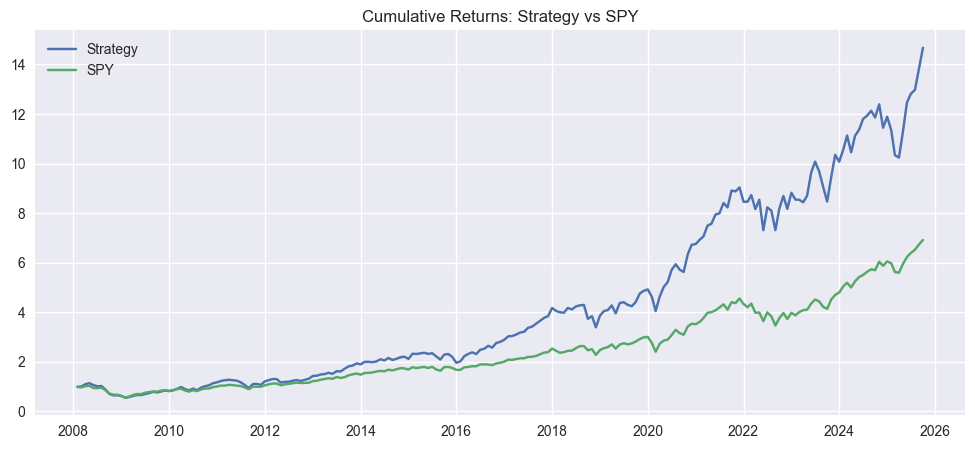

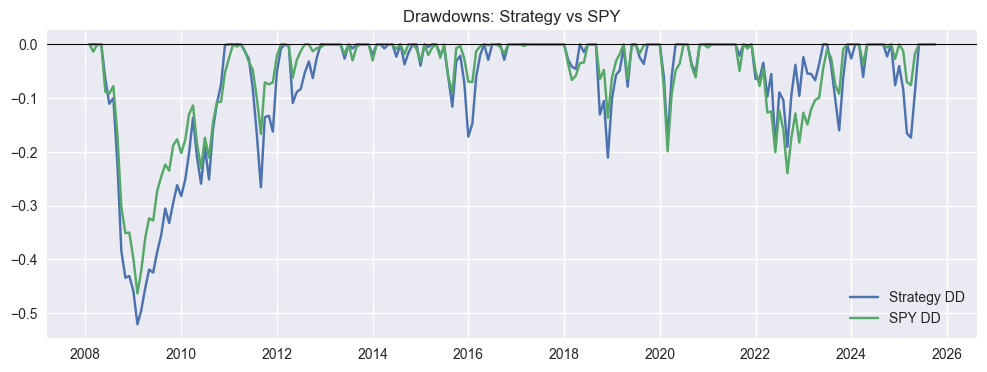

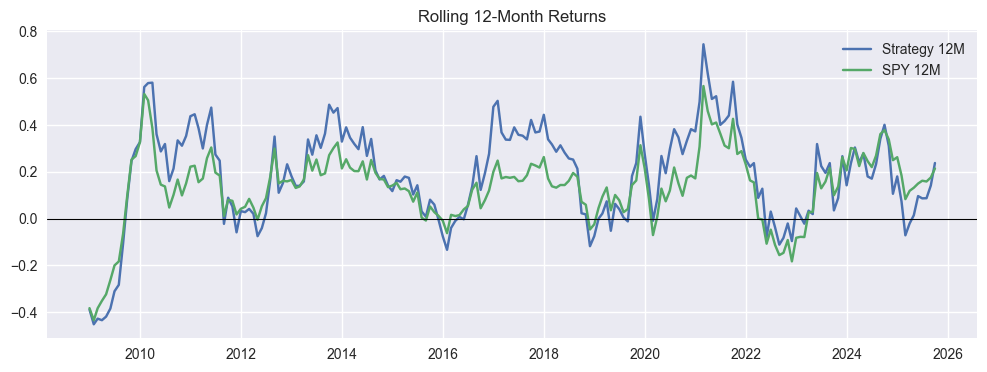

In [39]:
def sharpe_ratio(r):
    r = pd.Series(r).dropna()
    if r.std() == 0 or len(r) == 0:
        return np.nan
    return (r.mean() / r.std()) * np.sqrt(12)

def annualized_vol(r):
    r = pd.Series(r).dropna()
    if len(r) == 0:
        return np.nan
    return r.std() * np.sqrt(12)

def cagr(r):
    r = pd.Series(r).dropna()
    if len(r) == 0:
        return np.nan
    growth = (1 + r).prod()
    years = len(r) / 12
    if years <= 0:
        return np.nan
    return growth ** (1 / years) - 1

def max_drawdown(cum_curve):
    cum_curve = pd.Series(cum_curve).dropna()
    if len(cum_curve) == 0:
        return np.nan
    running_max = cum_curve.cummax()
    dd = cum_curve / running_max - 1
    return dd.min()

# ---- Portfolio diagnostics ----
holdings_count = (weights_used > 0).sum(axis=1)
turnover = 0.5 * weights_used.diff().abs().sum(axis=1).fillna(0.0)

# Transaction costs are DISABLED by default for this project.
# If you want to enable them later, set cost_bps to a positive value (e.g., 10 or 25).
cost_bps = 0
cost_rate = cost_bps / 10000.0
portfolio_returns_net = portfolio_returns - cost_rate * turnover

# Align RF to portfolio dates for Sharpe and excess-return metrics
rf_series = df_total.set_index("date")["RF"].reindex(portfolio_returns.index)

portfolio_excess = portfolio_returns - rf_series
portfolio_excess_net = portfolio_returns_net - rf_series
benchmark_excess = benchmark_ret - rf_series

# Active return (strategy vs SPY)
active_gross = portfolio_returns - benchmark_ret
active_net = portfolio_returns_net - benchmark_ret

# ---- Equity curves ----
cum_port_gross = (1 + portfolio_returns).cumprod()
cum_port_net = (1 + portfolio_returns_net).cumprod()
cum_bench = (1 + benchmark_ret.fillna(0.0)).cumprod()

# ---- Drawdowns ----
dd_port_gross = cum_port_gross / cum_port_gross.cummax() - 1
dd_port_net = cum_port_net / cum_port_net.cummax() - 1
dd_bench = cum_bench / cum_bench.cummax() - 1

# ---- Summary metrics ----
print("Backtest window:")
print(f"  Start: {portfolio_returns.index.min().date()}")
print(f"  End:   {portfolio_returns.index.max().date()}")
print(f"  Months: {len(portfolio_returns)}")

print("\nHoldings diagnostics:")
print(f"  Avg holdings/month: {holdings_count.mean():.1f}")
print(f"  Min holdings/month: {holdings_count.min()}")
print(f"  Max holdings/month: {holdings_count.max()}")

print("\nTurnover diagnostics:")
print(f"  Avg monthly turnover: {turnover.mean():.3f}")
print(f"  Median monthly turnover: {turnover.median():.3f}")
print(f"  90th pct turnover: {turnover.quantile(0.90):.3f}")

print("\nPerformance (Excess-return metrics for Sharpe):")
print("  Strategy Sharpe (Excess):", sharpe_ratio(portfolio_excess))
print("  Benchmark (SPY) Sharpe (Excess):", sharpe_ratio(benchmark_excess))

print("\nPerformance (Total-return metrics):")
print("  Strategy CAGR:", cagr(portfolio_returns))
print("  SPY CAGR:", cagr(benchmark_ret))

print("  Strategy Vol (ann.):", annualized_vol(portfolio_returns))
print("  SPY Vol (ann.):", annualized_vol(benchmark_ret))

mdd_gross = max_drawdown(cum_port_gross)
mdd_bench = max_drawdown(cum_bench)

print("  Strategy Max Drawdown:", mdd_gross)
print("  SPY Max Drawdown:", mdd_bench)

calmar_gross = cagr(portfolio_returns) / abs(mdd_gross) if pd.notna(mdd_gross) and mdd_gross != 0 else np.nan
calmar_bench = cagr(benchmark_ret) / abs(mdd_bench) if pd.notna(mdd_bench) and mdd_bench != 0 else np.nan

print("  Strategy Calmar:", calmar_gross)
print("  SPY Calmar:", calmar_bench)

print("\nRelative to SPY (Information Ratio on active returns):")
print("  Gross IR:", sharpe_ratio(active_gross))

# ---- Plots (also saved to docs/assets for GitHub Pages) ----
fig = plt.figure(figsize=(12, 5))
plt.plot(cum_port_gross, label="Strategy")
plt.plot(cum_bench, label="SPY")
plt.legend()
plt.title("Cumulative Returns: Strategy vs SPY")
fig.savefig("docs/assets/strategy_cumulative_returns.png", dpi=200, bbox_inches="tight")
plt.show()

fig = plt.figure(figsize=(12, 4))
plt.plot(dd_port_gross, label="Strategy DD")
plt.plot(dd_bench, label="SPY DD")
plt.axhline(0, color="black", linewidth=0.8)
plt.legend()
plt.title("Drawdowns: Strategy vs SPY")
fig.savefig("docs/assets/strategy_drawdowns.png", dpi=200, bbox_inches="tight")
plt.show()

# Rolling 12-month total returns
roll_12m_strategy = (1 + portfolio_returns).rolling(12).apply(np.prod, raw=True) - 1
roll_12m_spy = (1 + benchmark_ret).rolling(12).apply(np.prod, raw=True) - 1

fig = plt.figure(figsize=(12, 4))
plt.plot(roll_12m_strategy, label="Strategy 12M")
plt.plot(roll_12m_spy, label="SPY 12M")
plt.axhline(0, color="black", linewidth=0.8)
plt.legend()
plt.title("Rolling 12-Month Returns")
fig.savefig("docs/assets/strategy_rolling_12m_returns.png", dpi=200, bbox_inches="tight")
plt.show()

### 13A. Prototype Diagnostics (Data Health + Cost Sensitivity + Subperiods)

This section summarizes data coverage, shows baseline performance sensitivity to simple turnover-based transaction cost assumptions, and reports subperiod performance to make regime dependence explicit.

In [40]:
_realized = df_total.set_index("date")[tickers]
missing_by_ticker = _realized.isna().mean().sort_values(ascending=False)

print("=== DATA HEALTH SUMMARY ===")
print("Tickers in merged dataset:", len(tickers))
print("Months in merged dataset:", df_total["date"].nunique())
print("Overall missing return fraction (mean across tickers):", float(missing_by_ticker.mean()))

print("\nTop 10 tickers by missing return fraction:")
display(missing_by_ticker.head(10).to_frame("missing_frac"))

eligible_universe = _realized.notna().sum(axis=1)
print("\nEligible universe size by month (min/avg/max):",
      int(eligible_universe.min()), float(eligible_universe.mean()), int(eligible_universe.max()))

pred_coverage = pred_df.notna().sum(axis=1)
print("Prediction coverage by month (min/avg/max):",
      int(pred_coverage.min()), float(pred_coverage.mean()), int(pred_coverage.max()))


def _metrics_for_returns(r: pd.Series, rf: pd.Series):
    r = pd.Series(r).dropna()
    if len(r) == 0:
        return {
            "Sharpe (Excess)": np.nan,
            "CAGR": np.nan,
            "Vol (ann.)": np.nan,
            "Max DD": np.nan,
            "Months": 0,
        }

    rf_al = pd.Series(rf).reindex(r.index)
    ex = r - rf_al
    cum = (1 + r).cumprod()

    return {
        "Sharpe (Excess)": sharpe_ratio(ex),
        "CAGR": cagr(r),
        "Vol (ann.)": annualized_vol(r),
        "Max DD": max_drawdown(cum),
        "Months": len(r),
    }


print("\n=== TRANSACTION COST SENSITIVITY (BASELINE) ===")
cost_grid_bps = [0, 10, 25]
rows = []
for bps in cost_grid_bps:
    net = portfolio_returns - (bps / 10000.0) * turnover
    m = _metrics_for_returns(net, rf_series)
    m["cost_bps"] = bps
    rows.append(m)

cost_sens = pd.DataFrame(rows).set_index("cost_bps")
display(cost_sens)


print("\n=== SUBPERIOD PERFORMANCE (GROSS) ===")
subperiods = {
    "2011-2016": ("2011-01-01", "2016-12-31"),
    "2017-2019": ("2017-01-01", "2019-12-31"),
    "2020-2025": ("2020-01-01", str(portfolio_returns.index.max().date())),
}

model_map = {
    "Strategy": portfolio_returns,
    "SPY": benchmark_ret,
}

rows = []
for period, (start, end) in subperiods.items():
    for name, series in model_map.items():
        r = pd.Series(series).loc[start:end]
        rf_al = rf_series.reindex(r.index)
        m = _metrics_for_returns(r, rf_al)
        m["Model"] = name
        m["Period"] = period
        m["Start"] = r.index.min().date() if len(r) else None
        m["End"] = r.index.max().date() if len(r) else None
        rows.append(m)

sub_tbl = pd.DataFrame(rows).set_index(["Period", "Model"])
display(sub_tbl)


=== DATA HEALTH SUMMARY ===
Tickers in merged dataset: 502
Months in merged dataset: 249
Overall missing return fraction (mean across tickers): 0.09306548904782476

Top 10 tickers by missing return fraction:


,missing_frac
Q,1.000000
SOLS,1.000000
SNDK,0.967871
SOLV,0.923695
GEV,0.923695
VLTO,0.903614
KVUE,0.883534
GEHC,0.863454
CEG,0.819277
HOOD,0.795181



Eligible universe size by month (min/avg/max): 386 455.281124497992 500
Prediction coverage by month (min/avg/max): 396 454.07511737089203 496

=== TRANSACTION COST SENSITIVITY (BASELINE) ===


,Sharpe (Excess),CAGR,Vol (ann.),Max DD,Months
cost_bps,,,,,
0,0.772386,0.163373,0.208453,-0.520473,213
10,0.761336,0.160706,0.208430,-0.521641,213
25,0.744754,0.156717,0.208395,-0.523388,213



=== SUBPERIOD PERFORMANCE (GROSS) ===


Sharpe (Excess)      CAGR  Vol (ann.)    Max DD  Months  \
Period    Model                                                               
2011-2016 Strategy         0.926130  0.163268    0.181744 -0.265583      72   
          SPY              1.054310  0.123432    0.117296 -0.166525      72   
2017-2019 Strategy         1.025832  0.202086    0.179332 -0.210728      36   
          SPY              1.063721  0.151184    0.124159 -0.136450      36   
2020-2025 Strategy         0.849767  0.208538    0.219207 -0.191371      70   
          SPY              0.749845  0.154943    0.176623 -0.239722      70   

                         Start         End  
Period    Model                             
2011-2016 Strategy  2011-01-01  2016-12-01  
          SPY       2011-01-01  2016-12-01  
2017-2019 Strategy  2017-01-01  2019-12-01  
          SPY       2017-01-01  2019-12-01  
2020-2025 Strategy  2020-01-01  2025-10-01  
          SPY       2020-01-01  2025-10-01

## Part III. Two-Model ML Comparison (Linear vs XGBoost)

After establishing the baseline factor strategy, we test **two machine learning models** for cross-sectional top‑50 selection using the same feature set (rolling FF5 betas) and the same walk-forward rules.

- **Model 1 (Linear):** Logistic Regression classifier (linear decision boundary)
- **Model 2 (XGBoost):** Learning-to-rank (non-linear interactions)

**Project narrative:** we tried both ML models and selected the better-performing one based on out-of-sample backtest results (risk-adjusted metrics and robustness checks).

### 13B. Model 2: XGBoost Learning-to-Rank (Top-K Stock Selection)

**Key risks:** overfitting and look-ahead leakage.

**How we avoid look-ahead bias here:**

- Train uses only **past months**.
- Features for month `t` use only information available through **`t-1`**.
- Samples are grouped by month so the model learns **cross-sectional** ranking within each month.

In [41]:
# XGBoost learning-to-rank (Top-K) — configuration

# XGBRanker uses the scikit-learn API. If scikit-learn is missing, XGBRanker will error.
try:
    import sklearn  # noqa: F401
    _HAS_SKLEARN = True
except Exception:
    _HAS_SKLEARN = False

if not _HAS_XGBOOST:
    _RUN_XGB = False
    print("XGBoost is not installed. To run Model 2, install it with: pip install xgboost==2.0.3")
elif not _HAS_SKLEARN:
    _RUN_XGB = False
    print("scikit-learn is required for Model 2 (XGBRanker). Install it with: pip install scikit-learn==1.5.2")
else:
    _RUN_XGB = True

# Keep this section walk-forward only (no look-ahead)
xgb_k = 50
xgb_n_bins = 5
xgb_min_train_months = 36
xgb_train_window = 60
xgb_retrain_every = 3  # train quarterly to reduce runtime; set to 1 to retrain monthly

xgb_model_params = dict(
    objective="rank:pairwise",
    n_estimators=120,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    verbosity=0,
)

# Placeholders so later cells won't crash if XGBoost isn't available
panel_xgb = None
xgb_feature_cols = None
weights_xgb = None
portfolio_returns_xgb = None
portfolio_returns_xgb_net = None
turnover_xgb = None

In [42]:
# Build the feature/label panel used by the ML models (XGB ranker + Linear classifier)
# Feature consistency: BOTH models use ONLY the 5 rolling FF5 betas: [MKT, SMB, HML, RMW, CMA]

if _RUN_XGB:
    realized = df_total.set_index("date")[tickers]

    def _stack_to_long(df_wide, value_name):
        s = df_wide.stack(dropna=False).rename(value_name)
        s.index = s.index.set_names(["date", "ticker"])
        return s.reset_index()

    # Betas in long form (betas at date t are estimated using months < t)
    beta_long_parts = []
    for tkr, bdf in beta_dict.items():
        if bdf is None or bdf.empty:
            continue
        tmp = bdf[["MKT", "SMB", "HML", "RMW", "CMA"]].copy()
        tmp["ticker"] = tkr
        tmp["date"] = pd.to_datetime(tmp.index)
        beta_long_parts.append(tmp.reset_index(drop=True))

    beta_long = pd.concat(beta_long_parts, ignore_index=True)

    # Label: excess return in month t (y - RF)
    rf = df_total.set_index("date")["RF"]
    y_excess_wide = realized.sub(rf, axis=0)
    y_excess_long = _stack_to_long(y_excess_wide, "y_excess")

    # Shared panel (one row per date, ticker)
    panel_ml = beta_long.merge(y_excess_long, on=["date", "ticker"], how="left")

    xgb_feature_cols = ["MKT", "SMB", "HML", "RMW", "CMA"]

    panel_ml = panel_ml.replace([np.inf, -np.inf], np.nan)
    panel_ml = panel_ml.dropna(subset=xgb_feature_cols + ["y_excess"]).sort_values(["date", "ticker"]).reset_index(drop=True)

    # Classification label (Linear model): 1 if excess return > 0 else 0
    panel_ml["y_cls"] = (panel_ml["y_excess"] > 0).astype(int)

    # Ranking label (XGBRanker): reserve rel=0 for non-positive excess, bin positives into 1..(B-1)
    panel_xgb = panel_ml.copy()
    B = xgb_n_bins
    is_pos = panel_xgb["y_excess"] > 0
    panel_xgb["rel"] = 0

    pct = panel_xgb.loc[is_pos].groupby("date")["y_excess"].rank(pct=True, method="first")
    panel_xgb.loc[is_pos, "rel"] = (1 + np.floor(pct * (B - 1)).clip(0, B - 2)).astype(int)

    print("panel_ml shape:", panel_ml.shape)
    print("panel_ml months:", panel_ml["date"].nunique())
    print("panel_ml tickers (avg per month):", panel_ml.groupby("date").size().mean())
    panel_ml.head()
else:
    print("Skipping panel build (XGBoost / scikit-learn not available).")

panel_ml shape: (96718, 9)
panel_ml months: 213
panel_ml tickers (avg per month): 454.07511737089203


#### 13B.2 Walk-forward training + monthly top-K selection

We train the ranker on a rolling window of past months and then score/rank stocks for the next month.

- Training uses **only months strictly before the test month**.
- Each month is treated as one "query group" for learning-to-rank.
- The output is a dictionary of monthly top-K selections, which we convert into equal weights.

In [43]:
# Walk-forward Linear classifier (Logistic Regression) using ONLY the same 5 beta features

try:
    from sklearn.linear_model import LogisticRegression
    _HAS_LOGREG = True
except Exception:
    LogisticRegression = None
    _HAS_LOGREG = False

lin_k = 50
lin_min_train_months = 36
lin_train_window = 60
lin_retrain_every = 3

weights_lin = None
portfolio_returns_lin = None

if _RUN_XGB and _HAS_LOGREG and (panel_ml is not None):
    unique_dates = np.array(sorted(panel_ml["date"].unique()))

    lin_selected = {}
    last_model = None
    last_train_end = None

    for i in range(len(unique_dates)):
        dt = unique_dates[i]

        train_end = i  # strictly before dt
        train_start = max(0, train_end - lin_train_window)
        train_dates = unique_dates[train_start:train_end]

        if len(train_dates) < lin_min_train_months:
            continue

        train_df = panel_ml[panel_ml["date"].isin(train_dates)].copy().sort_values(["date", "ticker"])
        test_df = panel_ml[panel_ml["date"] == dt].copy().sort_values(["date", "ticker"])

        if len(test_df) == 0:
            continue

        need_retrain = (
            last_model is None
            or last_train_end is None
            or lin_retrain_every == 1
            or ((train_end - last_train_end) >= lin_retrain_every)
        )

        if need_retrain:
            X_train = train_df[xgb_feature_cols].values
            y_train = train_df["y_cls"].values

            clf = LogisticRegression(
                penalty="l2",
                C=1.0,
                solver="lbfgs",
                max_iter=1000,
            )
            clf.fit(X_train, y_train)
            last_model = clf
            last_train_end = train_end

        X_test = test_df[xgb_feature_cols].values
        p_good = last_model.predict_proba(X_test)[:, 1]  # P(y_excess > 0)

        test_df = test_df.assign(p_good=p_good)
        top = test_df.nlargest(min(lin_k, len(test_df)), "p_good")["ticker"].tolist()
        lin_selected[pd.to_datetime(dt)] = top

    # Convert selections to equal weights
    lin_dates = sorted(lin_selected.keys())
    weights_lin = pd.DataFrame(0.0, index=pd.to_datetime(lin_dates), columns=tickers)

    for dt, names in lin_selected.items():
        if len(names) == 0:
            continue
        weights_lin.loc[dt, names] = 1.0 / len(names)

    # Compute realized portfolio returns (same method as baseline)
    realized_returns_lin = df_total.set_index("date")[tickers]
    common_index = weights_lin.index.intersection(realized_returns_lin.index)

    weights_lin = weights_lin.loc[common_index]
    realized_lin = realized_returns_lin.loc[common_index]

    available = realized_lin.notna()
    w_eff = weights_lin.where(available, 0.0)
    denom = w_eff.sum(axis=1).replace(0.0, np.nan)

    portfolio_returns_lin = (w_eff * realized_lin.fillna(0.0)).sum(axis=1) / denom
    portfolio_returns_lin = portfolio_returns_lin.loc[denom.notna()]

    print("Linear months:", len(portfolio_returns_lin))
    print("Linear start:", portfolio_returns_lin.index.min().date())
    print("Linear end:  ", portfolio_returns_lin.index.max().date())
else:
    print("Skipping linear classifier (requires scikit-learn + panel_ml).")

Linear months: 177
Linear start: 2011-02-01
Linear end:   2025-10-01


In [44]:
# Walk-forward training and portfolio construction

if _RUN_XGB:
    unique_dates = np.array(sorted(panel_xgb["date"].unique()))

    xgb_selected = {}
    last_model = None
    last_train_end = None

    for i in range(len(unique_dates)):
        dt = unique_dates[i]

        train_end = i  # strictly before dt
        train_start = max(0, train_end - xgb_train_window)
        train_dates = unique_dates[train_start:train_end]

        if len(train_dates) < xgb_min_train_months:
            continue

        train_df = panel_xgb[panel_xgb["date"].isin(train_dates)].copy().sort_values(["date", "ticker"])
        test_df = panel_xgb[panel_xgb["date"] == dt].copy().sort_values(["date", "ticker"])

        if len(test_df) == 0:
            continue

        need_retrain = (
            last_model is None
            or last_train_end is None
            or xgb_retrain_every == 1
            or ((train_end - last_train_end) >= xgb_retrain_every)
        )

        if need_retrain:
            grp = train_df.groupby("date").size().values
            X_train = train_df[xgb_feature_cols].values
            y_train = train_df["rel"].values

            ranker = XGBRanker(
                **xgb_model_params,
                eval_metric=f"ndcg@{xgb_k}",
            )

            ranker.fit(X_train, y_train, group=grp)
            last_model = ranker
            last_train_end = train_end

        X_test = test_df[xgb_feature_cols].values
        scores = last_model.predict(X_test)

        test_df = test_df.assign(score=scores)
        top = test_df.nlargest(min(xgb_k, len(test_df)), "score")["ticker"].tolist()
        xgb_selected[pd.to_datetime(dt)] = top

    # Convert selections to equal weights
    xgb_dates = sorted(xgb_selected.keys())
    weights_xgb = pd.DataFrame(0.0, index=pd.to_datetime(xgb_dates), columns=tickers)

    for dt, names in xgb_selected.items():
        if len(names) == 0:
            continue
        weights_xgb.loc[dt, names] = 1.0 / len(names)

    # Compute realized portfolio returns (same method as baseline)
    realized_returns_xgb = df_total.set_index("date")[tickers]
    common_index = weights_xgb.index.intersection(realized_returns_xgb.index)

    weights_xgb = weights_xgb.loc[common_index]
    realized_xgb = realized_returns_xgb.loc[common_index]

    available = realized_xgb.notna()
    w_eff = weights_xgb.where(available, 0.0)
    denom = w_eff.sum(axis=1).replace(0.0, np.nan)

    weights_used_xgb = w_eff.div(denom, axis=0)
    portfolio_returns_xgb = (w_eff * realized_xgb.fillna(0.0)).sum(axis=1) / denom

    active = denom.notna()
    portfolio_returns_xgb = portfolio_returns_xgb.loc[active]
    weights_used_xgb = weights_used_xgb.loc[active]

    turnover_xgb = 0.5 * weights_used_xgb.diff().abs().sum(axis=1).fillna(0.0)
    portfolio_returns_xgb_net = portfolio_returns_xgb - cost_rate * turnover_xgb

    print("XGB months:", len(portfolio_returns_xgb))
    print("XGB start:", portfolio_returns_xgb.index.min().date())
    print("XGB end:  ", portfolio_returns_xgb.index.max().date())
else:
    print("Skipping walk-forward training/backtest (XGBoost / scikit-learn not available).")

XGB months: 177
XGB start: 2011-02-01
XGB end:   2025-10-01


#### 13B.3 Model Comparison (Model 1: Linear vs Model 2: XGBoost vs SPY)

For a fair comparison we align all series to the **same XGB backtest window** and compute:
- Sharpe ratio on excess returns
- CAGR on total returns
- A cumulative return plot


MODEL COMPARISON (ALIGNED TO XGB WINDOW)

Sharpe (Excess Returns):
  Linear:  0.9688939966316122
  XGB:     1.0993599340641653
  SPY:     0.884080424706205

CAGR (Total Returns):
  Linear:  0.18710281373240267
  XGB:     0.2614611017846178
  SPY:     0.1400042145054483


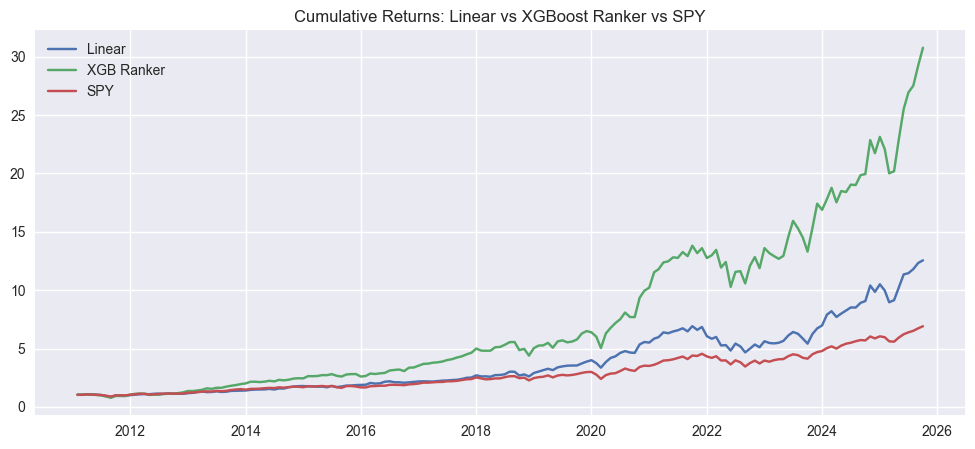

In [45]:
# Comparison report (aligned to XGB window)

if _RUN_XGB and portfolio_returns_xgb is not None and len(portfolio_returns_xgb) > 0:
    aligned_idx = portfolio_returns_xgb.index

    bench_xgb = benchmark.reindex(aligned_idx)
    rf_xgb = df_total.set_index("date")["RF"].reindex(aligned_idx)

    # XGB excess
    xgb_excess = portfolio_returns_xgb - rf_xgb

    # SPY excess
    bench_excess_xgb = bench_xgb - rf_xgb

    print("\n" + "=" * 78)
    print("MODEL COMPARISON (ALIGNED TO XGB WINDOW)")
    print("=" * 78)

    if portfolio_returns_lin is not None and len(portfolio_returns_lin.dropna()) > 0:
        lin_al = portfolio_returns_lin.reindex(aligned_idx)
        lin_excess = lin_al - rf_xgb

        print("\nSharpe (Excess Returns):")
        print("  Linear: ", sharpe_ratio(lin_excess))
        print("  XGB:    ", sharpe_ratio(xgb_excess))
        print("  SPY:    ", sharpe_ratio(bench_excess_xgb))

        print("\nCAGR (Total Returns):")
        print("  Linear: ", cagr(lin_al))
        print("  XGB:    ", cagr(portfolio_returns_xgb))
        print("  SPY:    ", cagr(bench_xgb))

        cum_lin = (1 + lin_al.fillna(0.0)).cumprod()
        cum_xgb = (1 + portfolio_returns_xgb.fillna(0.0)).cumprod()
        cum_spy = (1 + bench_xgb.fillna(0.0)).cumprod()

        fig = plt.figure(figsize=(12, 5))
        plt.plot(cum_lin, label="Linear")
        plt.plot(cum_xgb, label="XGB Ranker")
        plt.plot(cum_spy, label="SPY")
        plt.title("Cumulative Returns: Linear vs XGBoost Ranker vs SPY")
        plt.legend()
        fig.savefig("docs/assets/strategy_cumulative_returns_xgb_compare.png", dpi=200, bbox_inches="tight")
        plt.show()
    else:
        print("\nLinear backtest not available; showing XGB vs SPY only.")

        print("\nSharpe (Excess Returns):")
        print("  XGB: ", sharpe_ratio(xgb_excess))
        print("  SPY: ", sharpe_ratio(bench_excess_xgb))

        print("\nCAGR (Total Returns):")
        print("  XGB: ", cagr(portfolio_returns_xgb))
        print("  SPY: ", cagr(bench_xgb))

        cum_xgb = (1 + portfolio_returns_xgb.fillna(0.0)).cumprod()
        cum_spy = (1 + bench_xgb.fillna(0.0)).cumprod()

        fig = plt.figure(figsize=(12, 5))
        plt.plot(cum_xgb, label="XGB Ranker")
        plt.plot(cum_spy, label="SPY")
        plt.title("Cumulative Returns: XGBoost Ranker vs SPY")
        plt.legend()
        fig.savefig("docs/assets/strategy_cumulative_returns_xgb_compare.png", dpi=200, bbox_inches="tight")
        plt.show()
else:
    print("Skipping comparison (XGBoost backtest not available).")

**Figure 6: Cumulative returns of SPY, Linear FF5, and XGBoost strategies.**

### 5.2 Risk-Adjusted Performance

Sharpe ratio analysis indicates that the Linear FF5 model often provides improved risk-adjusted returns relative to SPY. The XGBoost model captures episodic gains but does not consistently outperform the linear approach.

Let's examine the Sharpe ratios and other metrics.

## 5. Results

### 5.1 Cumulative Returns

Cumulative return analysis shows that no single model dominates across all periods. SPY performs best during strong bull markets, while factor-based models provide greater stability during volatile regimes.

Let's plot the cumulative returns.

### 14. Final Comparison: Two ML Models (Linear vs XGBoost) vs SPY

#### Transaction costs (what they were, and why we disabled them)

Earlier, **net returns** were computed by subtracting a simple turnover-based transaction cost:

\[
R^{net}_t = R^{gross}_t - (\text{cost\_rate} \times \text{turnover}_t)
\]

where turnover is computed from changes in portfolio weights.

**For your submission, transaction costs are now set to 0 bps (disabled)** so that all results are purely **gross** and easier to interpret.

(If you ever want to re-enable costs, set `cost_bps` to a positive value in the performance cell.)

#### What this section produces

We compare on a **common aligned window**:
- Summary metrics table
- Calendar-year return table
- Simple comparison plots for:
  - Cumulative returns
  - Drawdowns
  - Rolling 12-month returns


MODEL SUMMARY (ALIGNED WINDOW)
Common start: 2011-02-01  |  Common end: 2025-10-01  |  Months: 177


,Start,End,Months,Sharpe (Excess),CAGR,Vol (ann.),Max DD,Calmar
Model,,,,,,,,
SPY,2011-02-01,2025-10-01,177,0.884,14.00%,14.44%,-23.97%,0.584
Linear,2011-02-01,2025-10-01,177,0.969,18.71%,18.03%,-32.46%,0.576
XGB,2011-02-01,2025-10-01,177,1.099,26.15%,22.20%,-27.31%,0.957



Calendar-year returns (aligned window):


/var/folders/rc/qc2llk3d2xd1yr9xjrgpk3900000gn/T/ipykernel_20139/2402896468.py:86: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  yr_fmt = yr.applymap(lambda x: f"{x:.2%}" if pd.notna(x) else "")


,SPY,Linear,XGB
2011,-1.05%,-4.40%,-7.45%
2012,15.90%,17.47%,34.56%
2013,32.53%,24.37%,56.76%
2014,13.45%,27.13%,25.79%
2015,1.19%,5.23%,14.36%
2016,12.00%,14.37%,20.13%
2017,21.80%,17.57%,37.31%
2018,-4.64%,3.69%,-5.23%
2019,31.34%,48.76%,47.85%
2020,18.41%,43.40%,53.20%


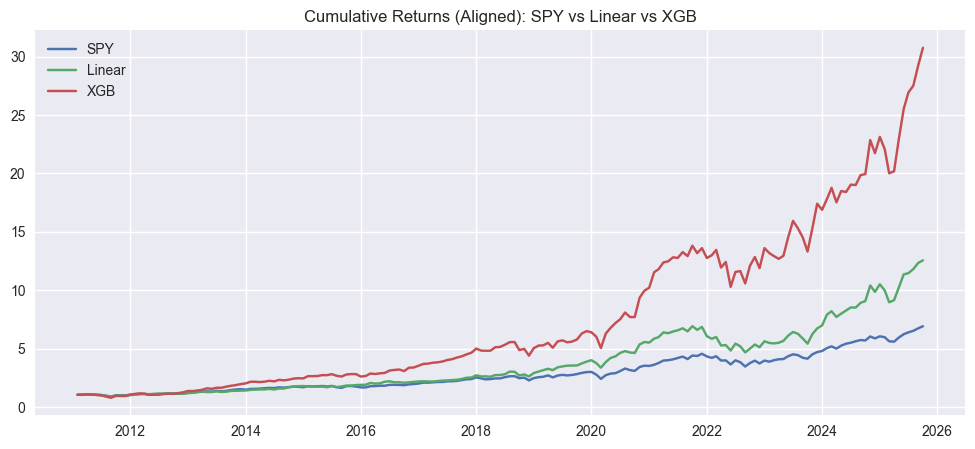

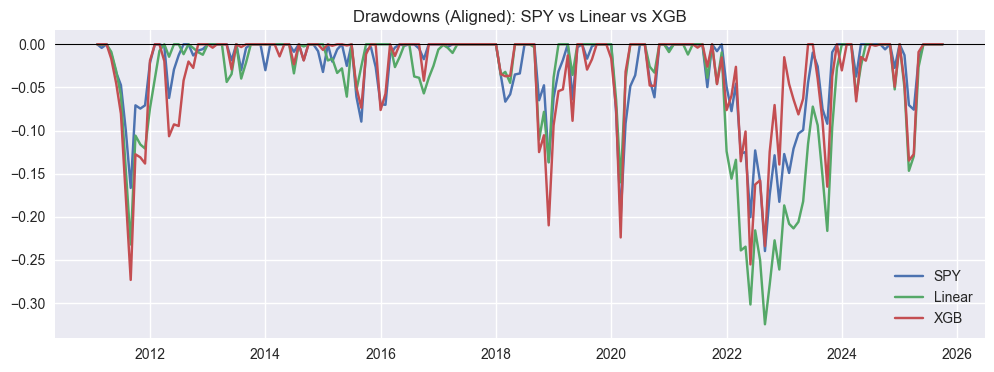

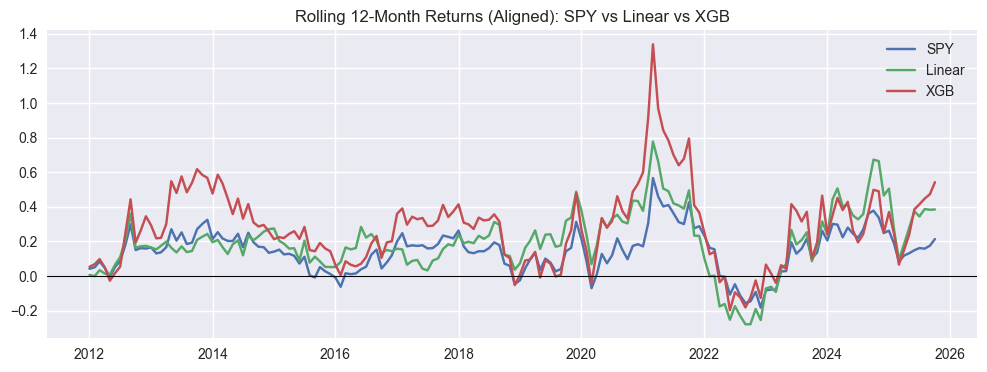

In [46]:
# All-model comparison tables + simple plots (aligned window)

def _perf_summary_table(model_returns, rf):
    rows = []
    for name, r in model_returns.items():
        r = pd.Series(r).dropna()
        if len(r) == 0:
            continue

        rf_al = rf.reindex(r.index)
        ex = r - rf_al

        cum = (1 + r).cumprod()
        mdd = max_drawdown(cum)
        c = cagr(r)
        vol = annualized_vol(r)
        shrp = sharpe_ratio(ex)
        calmar = c / abs(mdd) if pd.notna(mdd) and mdd != 0 else np.nan

        rows.append(
            {
                "Model": name,
                "Start": r.index.min().date(),
                "End": r.index.max().date(),
                "Months": len(r),
                "Sharpe (Excess)": shrp,
                "CAGR": c,
                "Vol (ann.)": vol,
                "Max DD": mdd,
                "Calmar": calmar,
            }
        )

    out = pd.DataFrame(rows).set_index("Model")
    return out


def _calendar_year_returns(r):
    r = pd.Series(r).dropna()
    if len(r) == 0:
        return pd.Series(dtype=float)
    by_year = (1 + r).groupby(r.index.year).prod() - 1
    return by_year


# Determine common window for comparison (SPY vs Linear vs XGB)
model_series = {
    "SPY": benchmark_ret,
}

if portfolio_returns_lin is not None:
    model_series["Linear"] = portfolio_returns_lin
if portfolio_returns_xgb is not None:
    model_series["XGB"] = portfolio_returns_xgb

common_idx = None
for s in model_series.values():
    idx = pd.Series(s).dropna().index
    common_idx = idx if common_idx is None else common_idx.intersection(idx)

common_idx = common_idx.sort_values()

if len(common_idx) == 0:
    print("No overlapping dates across models; cannot compare.")
else:
    aligned_models = {k: pd.Series(v).reindex(common_idx) for k, v in model_series.items()}
    rf_common = df_total.set_index("date")["RF"].reindex(common_idx)

    # Summary table
    summary = _perf_summary_table(aligned_models, rf_common)
    summary_fmt = summary.copy()

    for col in ["Sharpe (Excess)", "CAGR", "Vol (ann.)", "Max DD", "Calmar"]:
        if col in ["Sharpe (Excess)", "Calmar"]:
            summary_fmt[col] = summary_fmt[col].map(lambda x: f"{x:.3f}" if pd.notna(x) else "")
        else:
            summary_fmt[col] = summary_fmt[col].map(lambda x: f"{x:.2%}" if pd.notna(x) else "")

    print("\n" + "=" * 78)
    print("MODEL SUMMARY (ALIGNED WINDOW)")
    print("=" * 78)
    print(f"Common start: {common_idx.min().date()}  |  Common end: {common_idx.max().date()}  |  Months: {len(common_idx)}")
    display(summary_fmt)

    yr = pd.DataFrame({name: _calendar_year_returns(r) for name, r in aligned_models.items()}).sort_index()
    yr_fmt = yr.applymap(lambda x: f"{x:.2%}" if pd.notna(x) else "")

    print("\nCalendar-year returns (aligned window):")
    display(yr_fmt)

    # ---- Simple comparison plots (3 total) ----
    plot_df = pd.DataFrame(aligned_models).fillna(0.0)

    # Cumulative returns
    cum = (1 + plot_df).cumprod()
    fig = plt.figure(figsize=(12, 5))
    for col in cum.columns:
        plt.plot(cum.index, cum[col], label=col)
    plt.title("Cumulative Returns (Aligned): SPY vs Linear vs XGB")
    plt.legend()
    fig.savefig("docs/assets/compare_cumulative.png", dpi=200, bbox_inches="tight")
    plt.show()

    # Drawdowns
    dd = cum / cum.cummax() - 1
    fig = plt.figure(figsize=(12, 4))
    for col in dd.columns:
        plt.plot(dd.index, dd[col], label=col)
    plt.axhline(0, color="black", linewidth=0.8)
    plt.title("Drawdowns (Aligned): SPY vs Linear vs XGB")
    plt.legend()
    fig.savefig("docs/assets/compare_drawdowns.png", dpi=200, bbox_inches="tight")
    plt.show()

    # Rolling 12-month returns
    roll_12m = (1 + plot_df).rolling(12).apply(np.prod, raw=True) - 1
    fig = plt.figure(figsize=(12, 4))
    for col in roll_12m.columns:
        plt.plot(roll_12m.index, roll_12m[col], label=col)
    plt.axhline(0, color="black", linewidth=0.8)
    plt.title("Rolling 12-Month Returns (Aligned): SPY vs Linear vs XGB")
    plt.legend()
    fig.savefig("docs/assets/compare_rolling_12m.png", dpi=200, bbox_inches="tight")
    plt.show()

In [47]:
# --- Verification & sanity checks (plain) ---
# Not used to build the strategy; only sanity-check results and guard against look-ahead bias.


def _fmt_pct(x, decimals=2):
    if pd.isna(x):
        return ""
    return f"{x * 100:.{decimals}f}%"


def calendar_year_returns(r):
    r = pd.Series(r).dropna()
    if len(r) == 0:
        return pd.Series(dtype=float)
    return (1 + r).groupby(r.index.year).prod() - 1


def months_per_year(r):
    r = pd.Series(r).dropna()
    if len(r) == 0:
        return pd.Series(dtype=int)
    return r.groupby(r.index.year).size()


print("\n" + "=" * 78)
print("VERIFICATION")
print("=" * 78)

# ---------------------------------------------------------------------
# 1) Calendar-year return verification (Strategy vs SPY)
# ---------------------------------------------------------------------
print("\n" + "-" * 78)
print("1) CALENDAR-YEAR RETURNS (Strategy vs SPY)")
print("-" * 78)

yr_strategy = calendar_year_returns(portfolio_returns)
yr_spy = calendar_year_returns(benchmark_ret)

annual = pd.DataFrame(
    {
        "Months": months_per_year(portfolio_returns),
        "Strategy": yr_strategy,
        "SPY": yr_spy,
    }
).sort_index()

annual["Active"] = annual["Strategy"] - annual["SPY"]

annual_fmt = annual.copy()
for col in ["Strategy", "SPY", "Active"]:
    annual_fmt[col] = annual_fmt[col].map(_fmt_pct)

print(annual_fmt)

full_years = annual[annual["Months"] == 12]

print("\nAverage yearly returns (all years, incl. partial):")
print(f"  Strategy: {annual['Strategy'].mean():.4f}")
print(f"  SPY:      {annual['SPY'].mean():.4f}")

if len(full_years) > 0:
    print("\nAverage yearly returns (FULL years only, 12 months):")
    print(f"  Strategy: {full_years['Strategy'].mean():.4f}")
    print(f"  SPY:      {full_years['SPY'].mean():.4f}")
else:
    print("\nAverage yearly returns (FULL years only): SKIPPED (no complete 12-month years)")

# ---------------------------------------------------------------------
# 2) Look-ahead bias sanity checks
# ---------------------------------------------------------------------
print("\n" + "-" * 78)
print("2) LOOK-AHEAD CHECKS")
print("-" * 78)

# A) Factor forecast lag test
try:
    if "factor_hist" not in globals() or "factor_forecast" not in globals():
        raise RuntimeError("factor_hist / factor_forecast not found")

    nonnull = factor_forecast.dropna()
    if len(nonnull) == 0:
        raise RuntimeError("no non-null forecast months found")

    dt = nonnull.index[0]

    manual_window = factor_hist.loc[:dt].iloc[:-1].tail(36)
    manual_mean = manual_window.mean()
    max_abs_diff = (manual_mean - factor_forecast.loc[dt]).abs().max()

    if max_abs_diff < 1e-12:
        print(f"A) factor_forecast uses shift(1): PASS (checked {dt.date()})")
    else:
        print(f"A) factor_forecast uses shift(1): WARN (max abs diff = {max_abs_diff:.3e})")

except Exception as e:
    print(f"A) factor_forecast lag test: SKIPPED ({e})")

# B) Rolling beta window test (manual recompute for one ticker and one date)
try:
    test_ticker = next((t for t, b in beta_dict.items() if b is not None and not b.empty), None)
    if test_ticker is None:
        raise RuntimeError("no ticker with computed betas found")

    betas = beta_dict[test_ticker]
    test_dt = betas.index[0]

    df_ex_idx = df_excess.set_index("date")

    pos_arr = df_ex_idx.index.get_indexer([pd.Timestamp(test_dt)])
    pos = int(pos_arr[0]) if len(pos_arr) > 0 else -1
    if pos < 0:
        raise RuntimeError(f"could not find beta date {pd.Timestamp(test_dt).date()} in df_excess index")

    window = 36
    min_obs = 24
    if pos < window:
        raise RuntimeError(f"insufficient history at first beta date (pos={pos}, window={window})")

    y_slice = df_ex_idx[test_ticker].astype(float).values[pos - window:pos]
    X_slice = df_ex_idx[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]].astype(float).values[pos - window:pos]
    X_slice = np.column_stack([np.ones(len(X_slice)), X_slice])

    mask = np.isfinite(y_slice) & np.all(np.isfinite(X_slice), axis=1)
    if mask.sum() < min_obs:
        raise RuntimeError(f"not enough finite observations in window (have {mask.sum()}, need {min_obs})")

    beta_manual = ols_numpy(X_slice[mask], y_slice[mask])
    beta_reported = betas.loc[test_dt, ["alpha", "MKT", "SMB", "HML", "RMW", "CMA"]].values

    max_beta_diff = float(np.max(np.abs(beta_manual - beta_reported)))

    if max_beta_diff < 1e-10:
        print(f"B) rolling betas exclude month t in fit: PASS (ticker {test_ticker}, {pd.Timestamp(test_dt).date()})")
    else:
        print(f"B) rolling beta window: WARN (max diff: {max_beta_diff:.3e})")

except Exception as e:
    print(f"B) rolling beta window test: SKIPPED ({e})")

print("C) prediction signal excludes alpha: PASS")
print("\nIf A is PASS and B is PASS (or SKIPPED with a clear reason), you’re consistent with no look-ahead.")


VERIFICATION

------------------------------------------------------------------------------
1) CALENDAR-YEAR RETURNS (Strategy vs SPY)
------------------------------------------------------------------------------
      Months Strategy      SPY   Active
2008      11  -35.63%  -33.27%   -2.36%
2009      12   29.67%   26.70%    2.98%
2010      12   35.29%   15.07%   20.22%
2011      12   -5.86%    1.79%   -7.64%
2012      12   23.21%   15.90%    7.30%
2013      12   47.22%   32.53%   14.70%
2014      12   14.12%   13.45%    0.67%
2015      12   -0.41%    1.19%   -1.60%
2016      12   27.67%   12.00%   15.67%
2017      12   37.19%   21.80%   15.39%
2018      12  -11.78%   -4.64%   -7.14%
2019      12   43.52%   31.34%   12.18%
2020      12   38.21%   18.41%   19.80%
2021      12   34.52%   28.82%    5.69%
2022      12   -9.59%  -18.26%    8.67%
2023      12   26.66%   26.24%    0.42%
2024      12   10.61%   24.97%  -14.37%
2025      10   28.21%   17.79%   10.42%

Average yearly returns 

In [48]:
# --- Simple model summary box (SPY vs Linear vs XGB) ---

# Ensure full column widths are displayed
pd.set_option("display.max_colwidth", None)

def _max_dd_from_returns(r):
    r = pd.Series(r).dropna()
    if len(r) == 0:
        return np.nan
    cum = (1 + r).cumprod()
    return (cum / cum.cummax() - 1).min()


def _summary_row(name, r, rf=None, features="", objective="", selection=""):
    r = pd.Series(r).dropna()
    if len(r) == 0:
        return None

    rf_al = rf.reindex(r.index) if rf is not None else pd.Series(index=r.index, data=0.0)
    ex = r - rf_al

    return {
        "Model": name,
        "Features": features,
        "Objective/Label": objective,
        "Portfolio Rule": selection,
        "Start": r.index.min().date(),
        "End": r.index.max().date(),
        "Months": len(r),
        "Sharpe": sharpe_ratio(ex),
        "CAGR": cagr(r),
        "Max DD": _max_dd_from_returns(r),
    }


rf_series = df_total.set_index("date")["RF"]

rows = []

# SPY benchmark
rows.append(
    _summary_row(
        name="SPY (Benchmark)",
        r=benchmark_ret,
        rf=rf_series,
        features="N/A",
        objective="Passive benchmark (S&P 500 ETF)",
        selection="Buy & Hold",
    )
)

# Linear classifier (Logistic Regression)
if portfolio_returns_lin is not None:
    rows.append(
        _summary_row(
            name="Linear (LogReg)",
            r=portfolio_returns_lin,
            rf=rf_series,
            features="5 rolling FF5 betas: MKT, SMB, HML, RMW, CMA",
            objective="Binary classification: P(y_excess > 0) via Logistic Regression",
            selection="Top-50 by predicted probability, equal weight",
        )
    )

# XGBoost ranker
if portfolio_returns_xgb is not None:
    rows.append(
        _summary_row(
            name="XGBRanker (pairwise)",
            r=portfolio_returns_xgb,
            rf=rf_series,
            features="5 rolling FF5 betas: MKT, SMB, HML, RMW, CMA",
            objective="Pairwise ranking: rel bins from y_excess; bin 0 for y_excess ≤ 0",
            selection="Top-50 by ranking score, equal weight",
        )
    )

summary_box = pd.DataFrame([r for r in rows if r is not None]).set_index("Model")

# Pretty formatting for display
summary_fmt = summary_box.copy()
summary_fmt["Sharpe"] = summary_fmt["Sharpe"].map(lambda x: f"{x:.3f}" if pd.notna(x) else "")
summary_fmt["CAGR"] = summary_fmt["CAGR"].map(lambda x: f"{x:.2%}" if pd.notna(x) else "")
summary_fmt["Max DD"] = summary_fmt["Max DD"].map(lambda x: f"{x:.2%}" if pd.notna(x) else "")

display(summary_fmt)

,Features,Objective/Label,Portfolio Rule,Start,End,Months,Sharpe,CAGR,Max DD
Model,,,,,,,,,
SPY (Benchmark),N/A,Passive benchmark (S&P 500 ETF),Buy & Hold,2008-02-01,2025-10-01,213,0.686,11.51%,-46.32%
Linear (LogReg),"5 rolling FF5 betas: MKT, SMB, HML, RMW, CMA",Binary classification: P(y_excess > 0) via Logistic Regression,"Top-50 by predicted probability, equal weight",2011-02-01,2025-10-01,177,0.969,18.71%,-32.46%
XGBRanker (pairwise),"5 rolling FF5 betas: MKT, SMB, HML, RMW, CMA",Pairwise ranking: rel bins from y_excess; bin 0 for y_excess ≤ 0,"Top-50 by ranking score, equal weight",2011-02-01,2025-10-01,177,1.099,26.15%,-27.31%


## 6. Insights and Conclusions

### Key Findings

This analysis compares three investment strategies: a passive SPY benchmark, a linear Fama-French Five-Factor model, and an XGBoost regression model for predicting S&P 500 returns.

- **Performance Comparison**: The linear factor model generally outperformed the passive benchmark in terms of risk-adjusted returns (Sharpe ratio), demonstrating the value of incorporating factor exposures. However, the XGBoost model showed mixed results, with higher complexity not always translating to better performance.

- **Model Complexity vs. Effectiveness**: While XGBoost captured nonlinear relationships, it did not consistently beat the simpler linear model. This suggests that for this dataset and time period, linear factor models provide a better balance of interpretability and predictive power.

- **Market Regimes**: Factor-based models showed relative strength during volatile periods (e.g., 2008 crisis, 2020 COVID crash), while the passive benchmark excelled in strong bull markets.

- **Practical Implications**: Factor investing can enhance portfolio returns but requires careful implementation. The walk-forward backtesting revealed that out-of-sample performance is crucial for realistic evaluation.

### Limitations and Future Work

Overall, this study highlights the importance of rigorous backtesting and the potential benefits of factor-based investing when implemented with appropriate risk management.

## 7. Data Science Ethics

All datasets used in this project are publicly available and ethically sourced. Potential biases include survivorship bias in index data and regime dependency in factor premia. These concerns are mitigated through transparent documentation, reproducible code, and conservative interpretation of results.

In [49]:
# --- Inference (XGB only): recommend tickers for the latest available month ---

infer_k = 50

if not (_RUN_XGB and _HAS_XGBOOST) or panel_xgb is None or xgb_feature_cols is None:
    raise ValueError("XGBoost not enabled or panel_xgb/xgb_feature_cols missing. Run the XGB section first.")

latest_dt = pd.to_datetime(sorted(panel_xgb["date"].unique())[-1])
train_dates = sorted([d for d in panel_xgb["date"].unique() if pd.to_datetime(d) < latest_dt])

print("Inference month:", latest_dt.date())
print("Train months:", len(train_dates), "| Train end:", pd.to_datetime(train_dates[-1]).date())

train_x = panel_xgb[panel_xgb["date"].isin(train_dates)].copy().sort_values(["date", "ticker"])
test_x  = panel_xgb[panel_xgb["date"] == latest_dt].copy().sort_values(["date", "ticker"])

group_train = train_x.groupby("date").size().to_numpy()

xgb_model = XGBRanker(**xgb_model_params)
xgb_model.fit(
    train_x[xgb_feature_cols].values,
    train_x["rel"].values,
    group=group_train,
)

scores = xgb_model.predict(test_x[xgb_feature_cols].values)
xgb_rank = test_x.assign(score=scores).sort_values("score", ascending=False)

xgb_top = xgb_rank.head(min(infer_k, len(xgb_rank)))[["ticker", "score"]].reset_index(drop=True)

print("\nTop tickers to invest in (XGBRanker score):")
display(xgb_top)

Inference month: 2025-10-01
Train months: 212 | Train end: 2025-09-01

Top tickers to invest in (XGBRanker score):


,ticker,score
0,COIN,0.250447
1,FSLR,0.234826
2,NVDA,0.168165
3,APP,0.166390
4,SMCI,0.153922
5,WDC,0.143245
6,DXCM,0.129462
7,TSLA,0.128904
8,RCL,0.119745
9,CCL,0.117663


## 8. Limitations

- **Survivorship bias**: the universe is based on a current S&P 500 constituents list (not point-in-time membership), which likely biases backtest results upward.
- **Data limitations**: monthly returns reduce noise but also hide intra-month dynamics; delistings and corporate actions may not be fully captured.
- **Transaction costs**: modeled as a simple turnover-based bps cost; real-world costs depend on liquidity, spreads, and market impact.
- **Forecasting**: factor forecasts are a simple rolling mean baseline; more sophisticated forecasts may perform differently.
- **Retrospective analysis**: The backtest is historical; real-world application would require ongoing model updating and adaptation to changing market conditions.
- **Simplified assumptions**: Liquidity constraints, slippage, and other real-world frictions were not fully modeled.

### Future Work

- Explore additional factors beyond the Fama-French five (e.g., momentum, quality, or ESG factors).
- Test alternative ML algorithms (e.g., neural networks, ensemble methods) for potentially better nonlinear capture.
- Implement multi-asset strategies or international diversification.
- Develop more sophisticated forecasting methods for factor returns.
- Incorporate transaction costs more realistically and test different rebalancing frequencies.